In [ ]:
#| default_exp losses.pytorch

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# PyTorch Losses

> NeuralForecast contains a collection PyTorch Loss classes aimed to be used during the models' optimization.

The most important train signal is the forecast error, which is the difference between the observed value $y_{\tau}$ and the prediction $\hat{y}_{\tau}$, at time $y_{\tau}$:

$$e_{\tau} = y_{\tau}-\hat{y}_{\tau} \qquad \qquad \tau \in \{t+1,\dots,t+H \}$$

The train loss summarizes the forecast errors in different train optimization objectives.

All the losses are `torch.nn.modules` which helps to automatically moved them across CPU/GPU/TPU devices with Pytorch Lightning. 

In [ ]:
#| export
from typing import Optional, Union, Tuple, List

import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Distribution
from torch.distributions import (
    Bernoulli,
    Normal, 
    StudentT, 
    Poisson,
    NegativeBinomial,
    Beta,
    Gamma,
    MixtureSameFamily,
    Categorical,
    AffineTransform, 
    TransformedDistribution,
)

from torch.distributions import constraints
from functools import partial

In [ ]:
#| hide
import matplotlib.pyplot as plt
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

c:\Users\ospra\miniconda3\envs\neuralforecast-backup\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-01 17:20:21,171	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-01 17:20:21,397	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [ ]:
#| exporti
def _divide_no_nan(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    Auxiliary funtion to handle divide by 0
    """
    div = a / b
    return torch.nan_to_num(div, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
#| exporti
def _weighted_mean(losses, weights):
    """
    Compute weighted mean of losses per datapoint.
    """
    return _divide_no_nan(torch.sum(losses * weights), torch.sum(weights))

In [ ]:
#| export
class BasePointLoss(torch.nn.Module):
    """
    Base class for point loss functions.

    **Parameters:**<br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>
    `outputsize_multiplier`: Multiplier for the output size. <br>
    `output_names`: Names of the outputs. <br>
    """
    def __init__(self, horizon_weight=None, outputsize_multiplier=None, output_names=None):
        super(BasePointLoss, self).__init__()
        if horizon_weight is not None:
            horizon_weight = torch.Tensor(horizon_weight.flatten())
        self.horizon_weight = horizon_weight
        self.outputsize_multiplier = outputsize_multiplier
        self.output_names = output_names
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Input:
        Univariate: [B, H, 1]
        Multivariate: [B, H, N]

        Output: [B, H, N]
        """
        return y_hat

    def _compute_weights(self, y, mask):
        """
        Compute final weights for each datapoint (based on all weights and all masks)
        Set horizon_weight to a ones[H] tensor if not set.
        If set, check that it has the same length as the horizon in x.
        """
        if mask is None:
            mask = torch.ones_like(y)

        if self.horizon_weight is None:
            weights = torch.ones_like(mask)
        else:
            assert mask.shape[1] == len(self.horizon_weight), \
                'horizon_weight must have same length as Y'
            weights = self.horizon_weight.clone()
            weights = weights[None, :, None].to(mask.device)
            weights = torch.ones_like(mask, device=mask.device) * weights
        
        return weights * mask

# 1. Scale-dependent Errors

These metrics are on the same scale as the data.

## Mean Absolute Error (MAE)

In [ ]:
#| export
class MAE(BasePointLoss):
    """Mean Absolute Error

    Calculates Mean Absolute Error between
    `y` and `y_hat`. MAE measures the relative prediction
    accuracy of a forecasting method by calculating the
    deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    $$ \mathrm{MAE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} |y_{\\tau} - \hat{y}_{\\tau}| $$

    **Parameters:**<br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>
    """    
    def __init__(self, horizon_weight=None):
        super(MAE, self).__init__(horizon_weight=horizon_weight,
                                  outputsize_multiplier=1,
                                  output_names=[''])

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 y_insample: Union[torch.Tensor, None] = None) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies datapoints to consider in loss.<br>

        **Returns:**<br>
        `mae`: tensor (single value).
        """
        losses = torch.abs(y - y_hat)
        weights = self._compute_weights(y=y, mask=mask)
        return _weighted_mean(losses=losses, weights=weights)

In [ ]:
show_doc(MAE, name='MAE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L95){target="_blank" style="float:right; font-size:smaller"}

### MAE.__init__

>      MAE.__init__ (horizon_weight=None)

*Mean Absolute Error

Calculates Mean Absolute Error between
`y` and `y_hat`. MAE measures the relative prediction
accuracy of a forecasting method by calculating the
deviation of the prediction and the true
value at a given time and averages these devations
over the length of the series.

$$ \mathrm{MAE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} |y_{\tau} - \hat{y}_{\tau}| $$

**Parameters:**<br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>*

In [ ]:
show_doc(MAE.__call__, name='MAE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L116){target="_blank" style="float:right; font-size:smaller"}

### MAE.__call__

>      MAE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                    mask:Optional[torch.Tensor]=None,
>                    y_insample:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies datapoints to consider in loss.<br>

**Returns:**<br>
`mae`: tensor (single value).*

![](imgs_losses/mae_loss.png)

## Mean Squared Error (MSE)

In [ ]:
#| export
class MSE(BasePointLoss):
    """  Mean Squared Error

    Calculates Mean Squared Error between
    `y` and `y_hat`. MSE measures the relative prediction
    accuracy of a forecasting method by calculating the 
    squared deviation of the prediction and the true
    value at a given time, and averages these devations
    over the length of the series.
    
    $$ \mathrm{MSE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} (y_{\\tau} - \hat{y}_{\\tau})^{2} $$

    **Parameters:**<br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>
    """
    def __init__(self, horizon_weight=None):
        super(MSE, self).__init__(horizon_weight=horizon_weight,
                                  outputsize_multiplier=1,
                                  output_names=[''])

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies datapoints to consider in loss.<br>

        **Returns:**<br>
        `mse`: tensor (single value).
        """
        losses = (y - y_hat)**2
        weights = self._compute_weights(y=y, mask=mask)
        return _weighted_mean(losses=losses, weights=weights)

In [ ]:
show_doc(MSE, name='MSE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L136){target="_blank" style="float:right; font-size:smaller"}

### MSE.__init__

>      MSE.__init__ (horizon_weight=None)

*Mean Squared Error

Calculates Mean Squared Error between
`y` and `y_hat`. MSE measures the relative prediction
accuracy of a forecasting method by calculating the 
squared deviation of the prediction and the true
value at a given time, and averages these devations
over the length of the series.

$$ \mathrm{MSE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^{2} $$

**Parameters:**<br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>*

In [ ]:
show_doc(MSE.__call__, name='MSE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L157){target="_blank" style="float:right; font-size:smaller"}

### MSE.__call__

>      MSE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                    y_insample:torch.Tensor, mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies datapoints to consider in loss.<br>

**Returns:**<br>
`mse`: tensor (single value).*

![](imgs_losses/mse_loss.png)

## Root Mean Squared Error (RMSE)

In [ ]:
#| export
class RMSE(BasePointLoss):
    """ Root Mean Squared Error

    Calculates Root Mean Squared Error between
    `y` and `y_hat`. RMSE measures the relative prediction
    accuracy of a forecasting method by calculating the squared deviation
    of the prediction and the observed value at a given time and
    averages these devations over the length of the series.
    Finally the RMSE will be in the same scale
    as the original time series so its comparison with other
    series is possible only if they share a common scale. 
    RMSE has a direct connection to the L2 norm.
    
    $$ \mathrm{RMSE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\sqrt{\\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} (y_{\\tau} - \hat{y}_{\\tau})^{2}} $$

    **Parameters:**<br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>
    """
    def __init__(self, horizon_weight=None):
        super(RMSE, self).__init__(horizon_weight=horizon_weight,
                                  outputsize_multiplier=1,
                                  output_names=[''])

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 y_insample: Union[torch.Tensor, None] = None) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies datapoints to consider in loss.<br>

        **Returns:**<br>
        `rmse`: tensor (single value).
        """
        losses = (y - y_hat)**2
        weights = self._compute_weights(y=y, mask=mask)
        losses = _weighted_mean(losses=losses, weights=weights)
        return torch.sqrt(losses)

In [ ]:
show_doc(RMSE, name='RMSE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L177){target="_blank" style="float:right; font-size:smaller"}

### RMSE.__init__

>      RMSE.__init__ (horizon_weight=None)

*Root Mean Squared Error

Calculates Root Mean Squared Error between
`y` and `y_hat`. RMSE measures the relative prediction
accuracy of a forecasting method by calculating the squared deviation
of the prediction and the observed value at a given time and
averages these devations over the length of the series.
Finally the RMSE will be in the same scale
as the original time series so its comparison with other
series is possible only if they share a common scale. 
RMSE has a direct connection to the L2 norm.

$$ \mathrm{RMSE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \sqrt{\frac{1}{H} \sum^{t+H}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^{2}} $$

**Parameters:**<br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>*

In [ ]:
show_doc(RMSE.__call__, name='RMSE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L201){target="_blank" style="float:right; font-size:smaller"}

### RMSE.__call__

>      RMSE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                     mask:Optional[torch.Tensor]=None,
>                     y_insample:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies datapoints to consider in loss.<br>

**Returns:**<br>
`rmse`: tensor (single value).*

![](imgs_losses/rmse_loss.png)

# 2. Percentage errors

These metrics are unit-free, suitable for comparisons across series.

## Mean Absolute Percentage Error (MAPE)

In [ ]:
#| export
class MAPE(BasePointLoss):
    """ Mean Absolute Percentage Error

    Calculates Mean Absolute Percentage Error  between
    `y` and `y_hat`. MAPE measures the relative prediction
    accuracy of a forecasting method by calculating the percentual deviation
    of the prediction and the observed value at a given time and
    averages these devations over the length of the series.
    The closer to zero an observed value is, the higher penalty MAPE loss
    assigns to the corresponding error.

    $$ \mathrm{MAPE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \\frac{|y_{\\tau}-\hat{y}_{\\tau}|}{|y_{\\tau}|} $$

    **Parameters:**<br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

    **References:**<br>
    [Makridakis S., "Accuracy measures: theoretical and practical concerns".](https://www.sciencedirect.com/science/article/pii/0169207093900793)    
    """
    def __init__(self, horizon_weight=None):
        super(MAPE, self).__init__(horizon_weight=horizon_weight,
                                  outputsize_multiplier=1,
                                  output_names=[''])

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mape`: tensor (single value).
        """
        scale = _divide_no_nan(torch.ones_like(y, device=y.device), torch.abs(y))
        losses = torch.abs(y - y_hat) * scale
        weights = self._compute_weights(y=y, mask=mask)
        mape = _weighted_mean(losses=losses, weights=weights)
        return mape

In [ ]:
show_doc(MAPE, name='MAPE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L222){target="_blank" style="float:right; font-size:smaller"}

### MAPE.__init__

>      MAPE.__init__ (horizon_weight=None)

*Mean Absolute Percentage Error

Calculates Mean Absolute Percentage Error  between
`y` and `y_hat`. MAPE measures the relative prediction
accuracy of a forecasting method by calculating the percentual deviation
of the prediction and the observed value at a given time and
averages these devations over the length of the series.
The closer to zero an observed value is, the higher penalty MAPE loss
assigns to the corresponding error.

$$ \mathrm{MAPE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|} $$

**Parameters:**<br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

**References:**<br>
[Makridakis S., "Accuracy measures: theoretical and practical concerns".](https://www.sciencedirect.com/science/article/pii/0169207093900793)*

In [ ]:
show_doc(MAPE.__call__, name='MAPE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L247){target="_blank" style="float:right; font-size:smaller"}

### MAPE.__call__

>      MAPE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                     y_insample:torch.Tensor, mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mape`: tensor (single value).*

![](imgs_losses/mape_loss.png)

## Symmetric MAPE (sMAPE)

In [ ]:
#| export
class SMAPE(BasePointLoss):
    """ Symmetric Mean Absolute Percentage Error

    Calculates Symmetric Mean Absolute Percentage Error between
    `y` and `y_hat`. SMAPE measures the relative prediction
    accuracy of a forecasting method by calculating the relative deviation
    of the prediction and the observed value scaled by the sum of the
    absolute values for the prediction and observed value at a
    given time, then averages these devations over the length
    of the series. This allows the SMAPE to have bounds between
    0% and 200% which is desireble compared to normal MAPE that
    may be undetermined when the target is zero.

    $$ \mathrm{sMAPE}_{2}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \\frac{|y_{\\tau}-\hat{y}_{\\tau}|}{|y_{\\tau}|+|\hat{y}_{\\tau}|} $$

    **Parameters:**<br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

    **References:**<br>
    [Makridakis S., "Accuracy measures: theoretical and practical concerns".](https://www.sciencedirect.com/science/article/pii/0169207093900793)
    """
    def __init__(self, horizon_weight=None):
        super(SMAPE, self).__init__(horizon_weight=horizon_weight,
                                  outputsize_multiplier=1,
                                  output_names=[''])

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 y_insample: Union[torch.Tensor, None] = None) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `smape`: tensor (single value).
        """
        delta_y = torch.abs((y - y_hat))
        scale = torch.abs(y) + torch.abs(y_hat)
        losses = _divide_no_nan(delta_y, scale)
        weights = self._compute_weights(y=y, mask=mask)
        return 2*_weighted_mean(losses=losses, weights=weights)

In [ ]:
show_doc(SMAPE, name='SMAPE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L269){target="_blank" style="float:right; font-size:smaller"}

### SMAPE.__init__

>      SMAPE.__init__ (horizon_weight=None)

*Symmetric Mean Absolute Percentage Error

Calculates Symmetric Mean Absolute Percentage Error between
`y` and `y_hat`. SMAPE measures the relative prediction
accuracy of a forecasting method by calculating the relative deviation
of the prediction and the observed value scaled by the sum of the
absolute values for the prediction and observed value at a
given time, then averages these devations over the length
of the series. This allows the SMAPE to have bounds between
0% and 200% which is desireble compared to normal MAPE that
may be undetermined when the target is zero.

$$ \mathrm{sMAPE}_{2}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|+|\hat{y}_{\tau}|} $$

**Parameters:**<br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

**References:**<br>
[Makridakis S., "Accuracy measures: theoretical and practical concerns".](https://www.sciencedirect.com/science/article/pii/0169207093900793)*

In [ ]:
show_doc(SMAPE.__call__, name='SMAPE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L296){target="_blank" style="float:right; font-size:smaller"}

### SMAPE.__call__

>      SMAPE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                      mask:Optional[torch.Tensor]=None,
>                      y_insample:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`smape`: tensor (single value).*

# 3. Scale-independent Errors

These metrics measure the relative improvements versus baselines.

## Mean Absolute Scaled Error (MASE)

In [ ]:
#| export
class MASE(BasePointLoss):
    """ Mean Absolute Scaled Error 
    Calculates the Mean Absolute Scaled Error between
    `y` and `y_hat`. MASE measures the relative prediction
    accuracy of a forecasting method by comparinng the mean absolute errors
    of the prediction and the observed value against the mean
    absolute errors of the seasonal naive model.
    The MASE partially composed the Overall Weighted Average (OWA), 
    used in the M4 Competition.
    
    $$ \mathrm{MASE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}, \\mathbf{\hat{y}}^{season}_{\\tau}) = \\frac{1}{H} \sum^{t+H}_{\\tau=t+1} \\frac{|y_{\\tau}-\hat{y}_{\\tau}|}{\mathrm{MAE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{season}_{\\tau})} $$

    **Parameters:**<br>
    `seasonality`: int. Main frequency of the time series; Hourly 24,  Daily 7, Weekly 52, Monthly 12, Quarterly 4, Yearly 1.
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>
    
    **References:**<br>
    [Rob J. Hyndman, & Koehler, A. B. "Another look at measures of forecast accuracy".](https://www.sciencedirect.com/science/article/pii/S0169207006000239)<br>
    [Spyros Makridakis, Evangelos Spiliotis, Vassilios Assimakopoulos, "The M4 Competition: 100,000 time series and 61 forecasting methods".](https://www.sciencedirect.com/science/article/pii/S0169207019301128)
    """
    def __init__(self, seasonality: int, horizon_weight=None):
        super(MASE, self).__init__(horizon_weight=horizon_weight,
                                   outputsize_multiplier=1,
                                   output_names=[''])
        self.seasonality = seasonality

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor (batch_size, output_size), Actual values.<br>
        `y_hat`: tensor (batch_size, output_size)), Predicted values.<br>
        `y_insample`: tensor (batch_size, input_size), Actual insample values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mase`: tensor (single value).
        """
        delta_y = torch.abs(y - y_hat)
        scale = torch.mean(torch.abs(y_insample[:, self.seasonality:] - \
                                     y_insample[:, :-self.seasonality]), axis=1)
        losses = _divide_no_nan(delta_y, scale[:, None, None])
        weights = self._compute_weights(y=y, mask=mask)
        return _weighted_mean(losses=losses, weights=weights)

In [ ]:
show_doc(MASE, name='MASE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L318){target="_blank" style="float:right; font-size:smaller"}

### MASE.__init__

>      MASE.__init__ (seasonality:int, horizon_weight=None)

*Mean Absolute Scaled Error 
Calculates the Mean Absolute Scaled Error between
`y` and `y_hat`. MASE measures the relative prediction
accuracy of a forecasting method by comparinng the mean absolute errors
of the prediction and the observed value against the mean
absolute errors of the seasonal naive model.
The MASE partially composed the Overall Weighted Average (OWA), 
used in the M4 Competition.

$$ \mathrm{MASE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}, \mathbf{\hat{y}}^{season}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{\mathrm{MAE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{season}_{\tau})} $$

**Parameters:**<br>
`seasonality`: int. Main frequency of the time series; Hourly 24,  Daily 7, Weekly 52, Monthly 12, Quarterly 4, Yearly 1.
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

**References:**<br>
[Rob J. Hyndman, & Koehler, A. B. "Another look at measures of forecast accuracy".](https://www.sciencedirect.com/science/article/pii/S0169207006000239)<br>
[Spyros Makridakis, Evangelos Spiliotis, Vassilios Assimakopoulos, "The M4 Competition: 100,000 time series and 61 forecasting methods".](https://www.sciencedirect.com/science/article/pii/S0169207019301128)*

In [ ]:
show_doc(MASE.__call__, name='MASE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L345){target="_blank" style="float:right; font-size:smaller"}

### MASE.__call__

>      MASE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                     y_insample:torch.Tensor, mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor (batch_size, output_size), Actual values.<br>
`y_hat`: tensor (batch_size, output_size)), Predicted values.<br>
`y_insample`: tensor (batch_size, input_size), Actual insample values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mase`: tensor (single value).*

![](imgs_losses/mase_loss.png)

## Relative Mean Squared Error (relMSE)

In [ ]:
#| export
class relMSE(BasePointLoss):
    """Relative Mean Squared Error
    Computes Relative Mean Squared Error (relMSE), as proposed by Hyndman & Koehler (2006)
    as an alternative to percentage errors, to avoid measure unstability.
    $$ \mathrm{relMSE}(\\mathbf{y}, \\mathbf{\hat{y}}, \\mathbf{\hat{y}}^{benchmark}) =
    \\frac{\mathrm{MSE}(\\mathbf{y}, \\mathbf{\hat{y}})}{\mathrm{MSE}(\\mathbf{y}, \\mathbf{\hat{y}}^{benchmark})} $$

    **Parameters:**<br>
    `y_train`: numpy array, deprecated.<br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

    **References:**<br>
    - [Hyndman, R. J and Koehler, A. B. (2006).
       "Another look at measures of forecast accuracy",
       International Journal of Forecasting, Volume 22, Issue 4.](https://www.sciencedirect.com/science/article/pii/S0169207006000239)<br>
    - [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
       "Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. 
       Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
    """
    def __init__(self, y_train=None, horizon_weight=None):
        super(relMSE, self).__init__(horizon_weight=horizon_weight,
                                     outputsize_multiplier=1,
                                     output_names=[''])
        if y_train is not None:
            raise DeprecationWarning("y_train will be deprecated in a future release.")
        self.mse = MSE(horizon_weight=horizon_weight)

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_benchmark: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor (batch_size, output_size), Actual values.<br>
        `y_hat`: tensor (batch_size, output_size)), Predicted values.<br>
        `y_benchmark`: tensor (batch_size, output_size), Benchmark predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `relMSE`: tensor (single value).
        """
        norm = self.mse(y=y, y_hat=y_benchmark, mask=mask) # Already weighted
        norm = norm + 1e-5 # Numerical stability
        loss = self.mse(y=y, y_hat=y_hat, mask=mask) # Already weighted
        loss = _divide_no_nan(loss, norm)
        return loss

In [ ]:
show_doc(relMSE, name='relMSE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L374){target="_blank" style="float:right; font-size:smaller"}

### relMSE.__init__

>      relMSE.__init__ (y_train=None, horizon_weight=None)

*Relative Mean Squared Error
Computes Relative Mean Squared Error (relMSE), as proposed by Hyndman & Koehler (2006)
as an alternative to percentage errors, to avoid measure unstability.
$$ \mathrm{relMSE}(\mathbf{y}, \mathbf{\hat{y}}, \mathbf{\hat{y}}^{benchmark}) =
\frac{\mathrm{MSE}(\mathbf{y}, \mathbf{\hat{y}})}{\mathrm{MSE}(\mathbf{y}, \mathbf{\hat{y}}^{benchmark})} $$

**Parameters:**<br>
`y_train`: numpy array, deprecated.<br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

**References:**<br>
- [Hyndman, R. J and Koehler, A. B. (2006).
   "Another look at measures of forecast accuracy",
   International Journal of Forecasting, Volume 22, Issue 4.](https://www.sciencedirect.com/science/article/pii/S0169207006000239)<br>
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
   "Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. 
   Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)*

In [ ]:
show_doc(relMSE.__call__, name='relMSE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L401){target="_blank" style="float:right; font-size:smaller"}

### relMSE.__call__

>      relMSE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                       y_benchmark:torch.Tensor,
>                       mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor (batch_size, output_size), Actual values.<br>
`y_hat`: tensor (batch_size, output_size)), Predicted values.<br>
`y_benchmark`: tensor (batch_size, output_size), Benchmark predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`relMSE`: tensor (single value).*

# 4. Probabilistic Errors

These methods use statistical approaches for estimating unknown probability distributions using observed data. 

Maximum likelihood estimation involves finding the parameter values that maximize the likelihood function, which measures the probability of obtaining the observed data given the parameter values. MLE has good theoretical properties and efficiency under certain satisfied assumptions.

On the non-parametric approach, quantile regression measures non-symmetrically deviation, producing under/over estimation.

## Quantile Loss

In [ ]:
#| export
class QuantileLoss(BasePointLoss):
    """ Quantile Loss

    Computes the quantile loss between `y` and `y_hat`.
    QL measures the deviation of a quantile forecast.
    By weighting the absolute deviation in a non symmetric way, the
    loss pays more attention to under or over estimation.
    A common value for q is 0.5 for the deviation from the median (Pinball loss).

    $$ \mathrm{QL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q)}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \Big( (1-q)\,( \hat{y}^{(q)}_{\\tau} - y_{\\tau} )_{+} + q\,( y_{\\tau} - \hat{y}^{(q)}_{\\tau} )_{+} \Big) $$

    **Parameters:**<br>
    `q`: float, between 0 and 1. The slope of the quantile loss, in the context of quantile regression, the q determines the conditional quantile level.<br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

    **References:**<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)
    """
    def __init__(self, q, horizon_weight=None):
        super(QuantileLoss, self).__init__(horizon_weight=horizon_weight,
                                           outputsize_multiplier=1,
                                           output_names=[f'_ql{q}'])
        self.q = q

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies datapoints to consider in loss.<br>

        **Returns:**<br>
        `quantile_loss`: tensor (single value).
        """
        delta_y = y - y_hat
        losses = torch.max(torch.mul(self.q, delta_y), torch.mul((self.q - 1), delta_y))
        weights = self._compute_weights(y=y, mask=mask)
        return _weighted_mean(losses=losses, weights=weights)

In [ ]:
show_doc(QuantileLoss, name='QuantileLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L428){target="_blank" style="float:right; font-size:smaller"}

### QuantileLoss.__init__

>      QuantileLoss.__init__ (q, horizon_weight=None)

*Quantile Loss

Computes the quantile loss between `y` and `y_hat`.
QL measures the deviation of a quantile forecast.
By weighting the absolute deviation in a non symmetric way, the
loss pays more attention to under or over estimation.
A common value for q is 0.5 for the deviation from the median (Pinball loss).

$$ \mathrm{QL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q)}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \Big( (1-q)\,( \hat{y}^{(q)}_{\tau} - y_{\tau} )_{+} + q\,( y_{\tau} - \hat{y}^{(q)}_{\tau} )_{+} \Big) $$

**Parameters:**<br>
`q`: float, between 0 and 1. The slope of the quantile loss, in the context of quantile regression, the q determines the conditional quantile level.<br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

**References:**<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)*

In [ ]:
show_doc(QuantileLoss.__call__, name='QuantileLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L455){target="_blank" style="float:right; font-size:smaller"}

### QuantileLoss.__call__

>      QuantileLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                             y_insample:torch.Tensor,
>                             mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies datapoints to consider in loss.<br>

**Returns:**<br>
`quantile_loss`: tensor (single value).*

![](imgs_losses/q_loss.png)

## Multi Quantile Loss (MQLoss)

In [ ]:
#| exporti
def level_to_outputs(level):
    qs = sum([[50-l/2, 50+l/2] for l in level], [])
    output_names = sum([[f'-lo-{l}', f'-hi-{l}'] for l in level], [])

    sort_idx = np.argsort(qs)
    quantiles = np.array(qs)[sort_idx]

    # Add default median
    quantiles = np.concatenate([np.array([50]), quantiles])
    quantiles = torch.Tensor(quantiles) / 100
    output_names = list(np.array(output_names)[sort_idx])
    output_names.insert(0, '-median')
    
    return quantiles, output_names

def quantiles_to_outputs(quantiles):
    output_names = []
    for q in quantiles:
        if q<.50:
            output_names.append(f'-lo-{np.round(100-200*q,2)}')
        elif q>.50:
            output_names.append(f'-hi-{np.round(100-200*(1-q),2)}')
        else:
            output_names.append('-median')
    return quantiles, output_names

In [ ]:
#| export
class MQLoss(BasePointLoss):
    """  Multi-Quantile loss

    Calculates the Multi-Quantile loss (MQL) between `y` and `y_hat`.
    MQL calculates the average multi-quantile Loss for
    a given set of quantiles, based on the absolute 
    difference between predicted quantiles and observed values.
    
    $$ \mathrm{MQL}(\\mathbf{y}_{\\tau},[\\mathbf{\hat{y}}^{(q_{1})}_{\\tau}, ... ,\hat{y}^{(q_{n})}_{\\tau}]) = \\frac{1}{n} \\sum_{q_{i}} \mathrm{QL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q_{i})}_{\\tau}) $$
    
    The limit behavior of MQL allows to measure the accuracy 
    of a full predictive distribution $\mathbf{\hat{F}}_{\\tau}$ with 
    the continuous ranked probability score (CRPS). This can be achieved 
    through a numerical integration technique, that discretizes the quantiles 
    and treats the CRPS integral with a left Riemann approximation, averaging over 
    uniformly distanced quantiles.    
    
    $$ \mathrm{CRPS}(y_{\\tau}, \mathbf{\hat{F}}_{\\tau}) = \int^{1}_{0} \mathrm{QL}(y_{\\tau}, \hat{y}^{(q)}_{\\tau}) dq $$

    **Parameters:**<br>
    `level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
    `quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

    **References:**<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)<br>
    [James E. Matheson and Robert L. Winkler, "Scoring Rules for Continuous Probability Distributions".](https://www.jstor.org/stable/2629907)
    """
    def __init__(self, level=[80, 90], quantiles=None, horizon_weight=None):

        qs, output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)
        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, output_names = quantiles_to_outputs(quantiles)
            qs = torch.Tensor(quantiles)

        super(MQLoss, self).__init__(horizon_weight=horizon_weight,
                                     outputsize_multiplier=len(qs),
                                     output_names=output_names)
        
        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)

    def domain_map(self, y_hat: torch.Tensor):
        """
        Input:
        Univariate: [B, H, 1 * Q]
        Multivariate: [B, H, N * Q]

        Output: [B, H, N, Q]
        """
        output = y_hat.reshape(y_hat.shape[0],
                               y_hat.shape[1],
                               -1,
                               self.outputsize_multiplier)

        return output

    def _compute_weights(self, y, mask):
        """
        Compute final weights for each datapoint (based on all weights and all masks)
        Set horizon_weight to a ones[H] tensor if not set.
        If set, check that it has the same length as the horizon in x.

        y: [B, h, N, 1]
        mask: [B, h, N, 1]
        """

        if self.horizon_weight is None:
            weights = torch.ones_like(mask)
        else:
            assert mask.shape[1] == len(self.horizon_weight), \
                'horizon_weight must have same length as Y'    
            weights = self.horizon_weight.clone()
            weights = weights[None, :, None, None]
            weights = weights.to(mask.device)
            weights = torch.ones_like(mask, device=mask.device) * weights
        
        return weights * mask

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mqloss`: tensor (single value).
        """
        # [B, h, N] -> [B, h, N, 1]
        if y_hat.ndim == 3:
            y_hat = y_hat.unsqueeze(-1)

        y = y.unsqueeze(-1)
        if mask is not None:
            mask = mask.unsqueeze(-1)
        else:
            mask = torch.ones_like(y, device=y.device)

        error  = y_hat - y

        sq     = torch.maximum(-error, torch.zeros_like(error))
        s1_q   = torch.maximum(error, torch.zeros_like(error))
        
        quantiles = self.quantiles[None, None, None, :]
        losses = (1 / len(quantiles)) * (quantiles * sq + (1 - quantiles) * s1_q)
        weights = self._compute_weights(y=losses, mask=mask) # Use losses for extra dim

        return _weighted_mean(losses=losses, weights=weights)

In [ ]:
show_doc(MQLoss, name='MQLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L504){target="_blank" style="float:right; font-size:smaller"}

### MQLoss.__init__

>      MQLoss.__init__ (level=[80, 90], quantiles=None, horizon_weight=None)

*Multi-Quantile loss

Calculates the Multi-Quantile loss (MQL) between `y` and `y_hat`.
MQL calculates the average multi-quantile Loss for
a given set of quantiles, based on the absolute 
difference between predicted quantiles and observed values.

$$ \mathrm{MQL}(\mathbf{y}_{\tau},[\mathbf{\hat{y}}^{(q_{1})}_{\tau}, ... ,\hat{y}^{(q_{n})}_{\tau}]) = \frac{1}{n} \sum_{q_{i}} \mathrm{QL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q_{i})}_{\tau}) $$

The limit behavior of MQL allows to measure the accuracy 
of a full predictive distribution $\mathbf{\hat{F}}_{\tau}$ with 
the continuous ranked probability score (CRPS). This can be achieved 
through a numerical integration technique, that discretizes the quantiles 
and treats the CRPS integral with a left Riemann approximation, averaging over 
uniformly distanced quantiles.    

$$ \mathrm{CRPS}(y_{\tau}, \mathbf{\hat{F}}_{\tau}) = \int^{1}_{0} \mathrm{QL}(y_{\tau}, \hat{y}^{(q)}_{\tau}) dq $$

**Parameters:**<br>
`level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
`quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

**References:**<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)<br>
[James E. Matheson and Robert L. Winkler, "Scoring Rules for Continuous Probability Distributions".](https://www.jstor.org/stable/2629907)*

In [ ]:
show_doc(MQLoss.__call__, name='MQLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L578){target="_blank" style="float:right; font-size:smaller"}

### MQLoss.__call__

>      MQLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                       y_insample:torch.Tensor,
>                       mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mqloss`: tensor (single value).*

![](imgs_losses/mq_loss.png)

In [ ]:
# | hide
# Unit tests to check MQLoss' stored quantiles
# attribute is correctly instantiated
check = MQLoss(level=[80, 90])
test_eq(len(check.quantiles), 5)

check = MQLoss(quantiles=[0.0100, 0.1000, 0.5, 0.9000, 0.9900])
print(check.output_names)
print(check.quantiles)
test_eq(len(check.quantiles), 5)

check = MQLoss(quantiles=[0.0100, 0.1000, 0.9000, 0.9900])
test_eq(len(check.quantiles), 4)

['-lo-98.0', '-lo-80.0', '-median', '-hi-80.0', '-hi-98.0']
Parameter containing:
tensor([0.0100, 0.1000, 0.5000, 0.9000, 0.9900])


## Implicit Quantile Loss (IQLoss)

In [ ]:
#| export
class QuantileLayer(nn.Module):
    r"""
    Implicit Quantile Layer from the paper ``IQN for Distributional
    Reinforcement Learning`` (https://arxiv.org/abs/1806.06923) by
    Dabney et al. 2018.

    Code from GluonTS: https://github.com/awslabs/gluonts/blob/61133ef6e2d88177b32ace4afc6843ab9a7bc8cd/src/gluonts/torch/distributions/implicit_quantile_network.py

    """

    def __init__(self, num_output: int, cos_embedding_dim: int = 128):
        super().__init__()

        self.output_layer = nn.Sequential(
            nn.Linear(cos_embedding_dim, cos_embedding_dim),
            nn.PReLU(),
            nn.Linear(cos_embedding_dim, num_output),
        )

        self.register_buffer("integers", torch.arange(0, cos_embedding_dim))

    def forward(self, tau: torch.Tensor) -> torch.Tensor: 
        cos_emb_tau = torch.cos(tau * self.integers * torch.pi)
        return self.output_layer(cos_emb_tau)


class IQLoss(QuantileLoss):
    """Implicit Quantile Loss

    Computes the quantile loss between `y` and `y_hat`, with the quantile `q` provided as an input to the network. 
    IQL measures the deviation of a quantile forecast.
    By weighting the absolute deviation in a non symmetric way, the
    loss pays more attention to under or over estimation.

    $$ \mathrm{QL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q)}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \Big( (1-q)\,( \hat{y}^{(q)}_{\\tau} - y_{\\tau} )_{+} + q\,( y_{\\tau} - \hat{y}^{(q)}_{\\tau} )_{+} \Big) $$

    **Parameters:**<br>
    `quantile_sampling`: str, default='uniform', sampling distribution used to sample the quantiles during training. Choose from ['uniform', 'beta']. <br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

    **References:**<br>
    [Gouttes, Adèle, Kashif Rasul, Mateusz Koren, Johannes Stephan, and Tofigh Naghibi, "Probabilistic Time Series Forecasting with Implicit Quantile Networks".](http://arxiv.org/abs/2107.03743)
    """
    def __init__(self, cos_embedding_dim = 64, concentration0 = 1.0, concentration1 = 1.0, horizon_weight=None):
        self.update_quantile()
        super(IQLoss, self).__init__(
            q = self.q,
            horizon_weight=horizon_weight
        )

        self.cos_embedding_dim = cos_embedding_dim
        self.concentration0 = concentration0
        self.concentration1 = concentration1
        self.has_sampled = False
        self.has_predicted = False

        self.quantile_layer = QuantileLayer(
            num_output=1, cos_embedding_dim=self.cos_embedding_dim
        )
        self.output_layer = nn.Sequential(
            nn.Linear(1, 1), nn.PReLU()
        )
        
    def _sample_quantiles(self, sample_size, device):
        if not self.has_sampled:
            self._init_sampling_distribution(device)

        quantiles = self.sampling_distr.sample(sample_size)
        self.has_sampled = True        
        self.has_predicted = False

        return quantiles
    
    def _init_sampling_distribution(self, device):
        concentration0 = torch.tensor([self.concentration0],
                                      device=device,
                                      dtype=torch.float32)
        concentration1 = torch.tensor([self.concentration1],
                                      device=device,
                                      dtype=torch.float32)        
        self.sampling_distr = Beta(concentration0 = concentration0,
                                   concentration1 = concentration1)

    def update_quantile(self, q: List[float] = [0.5]):
        self.q = q[0]
        self.output_names = [f"_ql{q[0]}"]
        self.has_predicted = True

    def domain_map(self, y_hat):
        """
        Adds IQN network to output of network

        Input shapes to this function:
         
        Univariate: y_hat = [B, h, 1] 
        Multivariate: y_hat = [B, h, N]
        """
        if self.eval() and self.has_predicted:
            quantiles = torch.full(size=y_hat.shape, 
                                    fill_value=self.q,
                                    device=y_hat.device,
                                    dtype=y_hat.dtype) 
            quantiles = quantiles.unsqueeze(-1)             
        else:
            quantiles = self._sample_quantiles(sample_size=y_hat.shape,
                                        device=y_hat.device)

        # Embed the quantiles and add to y_hat
        emb_taus = self.quantile_layer(quantiles)
        emb_inputs = y_hat.unsqueeze(-1) * (1.0 + emb_taus)
        emb_outputs = self.output_layer(emb_inputs)
        
        # Domain map
        y_hat = emb_outputs.squeeze(-1)

        return y_hat


In [ ]:
show_doc(IQLoss, name='IQLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L643){target="_blank" style="float:right; font-size:smaller"}

### IQLoss.__init__

>      IQLoss.__init__ (cos_embedding_dim=64, concentration0=1.0,
>                       concentration1=1.0, horizon_weight=None)

*Implicit Quantile Loss

Computes the quantile loss between `y` and `y_hat`, with the quantile `q` provided as an input to the network. 
IQL measures the deviation of a quantile forecast.
By weighting the absolute deviation in a non symmetric way, the
loss pays more attention to under or over estimation.

$$ \mathrm{QL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q)}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \Big( (1-q)\,( \hat{y}^{(q)}_{\tau} - y_{\tau} )_{+} + q\,( y_{\tau} - \hat{y}^{(q)}_{\tau} )_{+} \Big) $$

**Parameters:**<br>
`quantile_sampling`: str, default='uniform', sampling distribution used to sample the quantiles during training. Choose from ['uniform', 'beta']. <br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

**References:**<br>
[Gouttes, Adèle, Kashif Rasul, Mateusz Koren, Johannes Stephan, and Tofigh Naghibi, "Probabilistic Time Series Forecasting with Implicit Quantile Networks".](http://arxiv.org/abs/2107.03743)*

In [ ]:
show_doc(IQLoss.__call__, name='IQLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L455){target="_blank" style="float:right; font-size:smaller"}

### IQLoss.__call__

>      IQLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                       y_insample:torch.Tensor,
>                       mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies datapoints to consider in loss.<br>

**Returns:**<br>
`quantile_loss`: tensor (single value).*

In [ ]:
# | hide
# Unit tests
# Check that default quantile is set to 0.5 at initialization
check = IQLoss()
test_eq(check.q, 0.5)

# Check that quantiles are correctly updated - prediction
check = IQLoss()
check.update_quantile([0.7])
test_eq(check.q, 0.7)

## DistributionLoss

In [ ]:
#| exporti
def weighted_average(x: torch.Tensor, 
                     weights: Optional[torch.Tensor]=None, dim=None) -> torch.Tensor:
    """
    Computes the weighted average of a given tensor across a given dim, masking
    values associated with weight zero,
    meaning instead of `nan * 0 = nan` you will get `0 * 0 = 0`.

    **Parameters:**<br>
    `x`: Input tensor, of which the average must be computed.<br>
    `weights`: Weights tensor, of the same shape as `x`.<br>
    `dim`: The dim along which to average `x`.<br>

    **Returns:**<br>
    `Tensor`: The tensor with values averaged along the specified `dim`.<br>
    """
    if weights is not None:
        weighted_tensor = torch.where(
            weights != 0, x * weights, torch.zeros_like(x)
        )
        sum_weights = torch.clamp(
            weights.sum(dim=dim) if dim else weights.sum(), min=1.0
        )
        return (
            weighted_tensor.sum(dim=dim) if dim else weighted_tensor.sum()
        ) / sum_weights
    else:
        return x.mean(dim=dim)

In [ ]:
#| exporti
def bernoulli_scale_decouple(output, loc=None, scale=None):
    """ Bernoulli Scale Decouple

    Stabilizes model's output optimization, by learning residual
    variance and residual location based on anchoring `loc`, `scale`.
    Also adds Bernoulli domain protection to the distribution parameters.
    """
    probs = output[0]
    #if (loc is not None) and (scale is not None):
    #    rate = (rate * scale) + loc
    probs = F.sigmoid(probs)#.clone()
    return (probs,)

def student_scale_decouple(output, loc=None, scale=None, eps: float=0.1):
    """ Normal Scale Decouple

    Stabilizes model's output optimization, by learning residual
    variance and residual location based on anchoring `loc`, `scale`.
    Also adds StudentT domain protection to the distribution parameters.
    """
    df, mean, tscale = output
    tscale = F.softplus(tscale)
    if (loc is not None) and (scale is not None):
        mean = (mean * scale) + loc
        tscale = (tscale + eps) * scale
    df = 3.0 + F.softplus(df)
    return (df, mean, tscale)

def normal_scale_decouple(output, loc=None, scale=None, eps: float=0.2):
    """ Normal Scale Decouple

    Stabilizes model's output optimization, by learning residual
    variance and residual location based on anchoring `loc`, `scale`.
    Also adds Normal domain protection to the distribution parameters.
    """
    mean, std = output
    std = F.softplus(std)
    if (loc is not None) and (scale is not None):
        mean = (mean * scale) + loc
        std = (std + eps) * scale
    return (mean, std)

def poisson_scale_decouple(output, loc=None, scale=None):
    """ Poisson Scale Decouple

    Stabilizes model's output optimization, by learning residual
    variance and residual location based on anchoring `loc`, `scale`.
    Also adds Poisson domain protection to the distribution parameters.
    """
    eps  = 1e-10
    rate = output[0]
    if (loc is not None) and (scale is not None):
        rate = (rate * scale) + loc
    rate = F.softplus(rate) + eps
    return (rate, )

def nbinomial_scale_decouple(output, loc=None, scale=None):
    """ Negative Binomial Scale Decouple

    Stabilizes model's output optimization, by learning total
    count and logits based on anchoring `loc`, `scale`.
    Also adds Negative Binomial domain protection to the distribution parameters.
    """
    mu, alpha = output
    mu = F.softplus(mu) + 1e-8
    alpha = F.softplus(alpha) + 1e-8    # alpha = 1/total_counts
    if (loc is not None) and (scale is not None):
        mu = mu * scale + loc
        alpha /= (scale + 1.)

    # mu = total_count * (probs/(1-probs))
    # => probs = mu / (total_count + mu)
    # => probs = mu / [total_count * (1 + mu * (1/total_count))]
    total_count = 1.0 / alpha
    probs = (mu * alpha / (1.0 + mu * alpha)) + 1e-8
    return (total_count, probs)

In [ ]:
#| exporti
def est_lambda(mu, rho):
    return mu ** (2 - rho) / (2 - rho)

def est_alpha(rho):
    return (2 - rho) / (rho - 1)

def est_beta(mu, rho):
    return mu ** (1 - rho) / (rho - 1)


class Tweedie(Distribution):
    """ Tweedie Distribution

    The Tweedie distribution is a compound probability, special case of exponential
    dispersion models EDMs defined by its mean-variance relationship.
    The distribution particularly useful to model sparse series as the probability has
    possitive mass at zero but otherwise is continuous.

    $Y \sim \mathrm{ED}(\\mu,\\sigma^{2}) \qquad
    \mathbb{P}(y|\\mu ,\\sigma^{2})=h(\\sigma^{2},y) \\exp \\left({\\frac {\\theta y-A(\\theta )}{\\sigma^{2}}}\\right)$<br>
    
    $\mu =A'(\\theta ) \qquad \mathrm{Var}(Y) = \\sigma^{2} \\mu^{\\rho}$
    
    Cases of the variance relationship include Normal (`rho` = 0), Poisson (`rho` = 1),
    Gamma (`rho` = 2), inverse Gaussian (`rho` = 3).

    **Parameters:**<br>
    `log_mu`: tensor, with log of means.<br>
    `rho`: float, Tweedie variance power (1,2). Fixed across all observations.<br>
    `sigma2`: tensor, Tweedie variance. Currently fixed in 1.<br>

    **References:**<br>
    - [Tweedie, M. C. K. (1984). An index which distinguishes between some important exponential families. Statistics: Applications and New Directions. 
    Proceedings of the Indian Statistical Institute Golden Jubilee International Conference (Eds. J. K. Ghosh and J. Roy), pp. 579-604. Calcutta: Indian Statistical Institute.]()<br>
    - [Jorgensen, B. (1987). Exponential Dispersion Models. Journal of the Royal Statistical Society. 
       Series B (Methodological), 49(2), 127–162. http://www.jstor.org/stable/2345415](http://www.jstor.org/stable/2345415)<br>
    """
    arg_constraints = {'log_mu': constraints.real}
    support = constraints.nonnegative

    def __init__(self, log_mu, rho, validate_args=None):
        # TODO: add sigma2 dispersion
        # TODO add constraints
        # support = constraints.real
        self.log_mu = log_mu
        self.rho = rho
        assert rho>1 and rho<2, f'rho={rho} parameter needs to be between (1,2).'

        batch_shape = log_mu.size()
        super(Tweedie, self).__init__(batch_shape, validate_args=validate_args)

    @property
    def mean(self):
        return torch.exp(self.log_mu)

    @property
    def variance(self):
        return torch.ones_line(self.log_mu) #TODO need to be assigned

    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            mu   = self.mean
            rho  = self.rho * torch.ones_like(mu)
            sigma2 = 1 #TODO

            rate  = est_lambda(mu, rho) / sigma2  # rate for poisson
            alpha = est_alpha(rho)                # alpha for Gamma distribution
            beta  = est_beta(mu, rho) / sigma2    # beta for Gamma distribution
            
            # Expand for sample
            rate = rate.expand(shape)
            alpha = alpha.expand(shape)
            beta = beta.expand(shape)

            N = torch.poisson(rate) + 1e-5
            gamma = Gamma(N*alpha, beta)
            samples = gamma.sample()
            samples[N==0] = 0

            return samples

    def log_prob(self, y_true):
        rho = self.rho
        y_pred = self.log_mu

        a = y_true * torch.exp((1 - rho) * y_pred) / (1 - rho)
        b = torch.exp((2 - rho) * y_pred) / (2 - rho)

        return a - b

def tweedie_domain_map(input: torch.Tensor, rho: float = 1.5):
    """
    Maps output of neural network to domain of distribution loss

    """
    return (input, rho)

def tweedie_scale_decouple(output, loc=None, scale=None):
    """Tweedie Scale Decouple

    Stabilizes model's output optimization, by learning total
    count and logits based on anchoring `loc`, `scale`.
    Also adds Tweedie domain protection to the distribution parameters.
    """
    log_mu, rho = output
    log_mu = F.softplus(log_mu)
    log_mu = torch.clamp(log_mu, 1e-9, 37)
    if (loc is not None) and (scale is not None):
        log_mu += torch.log(loc)

    log_mu = torch.clamp(log_mu, 1e-9, 37)
    return (log_mu, rho)

In [ ]:
#| exporti
# Code adapted from: https://github.com/awslabs/gluonts/blob/61133ef6e2d88177b32ace4afc6843ab9a7bc8cd/src/gluonts/torch/distributions/isqf.py

class ISQF(TransformedDistribution):
    """
    Distribution class for the Incremental (Spline) Quantile Function.
    
    **Parameters:**<br>
    `spline_knots`: Tensor parametrizing the x-positions of the spline knots. Shape: (*batch_shape, (num_qk-1), num_pieces)
    `spline_heights`: Tensor parametrizing the y-positions of the spline knots. Shape: (*batch_shape, (num_qk-1), num_pieces)
    `beta_l`: Tensor containing the non-negative learnable parameter of the left tail. Shape: (*batch_shape,)
    `beta_r`: Tensor containing the non-negative learnable parameter of the right tail. Shape: (*batch_shape,)
    `qk_y`: Tensor containing the increasing y-positions of the quantile knots. Shape: (*batch_shape, num_qk)
    `qk_x`: Tensor containing the increasing x-positions of the quantile knots. Shape: (*batch_shape, num_qk)
    `loc`: Tensor containing the location in case of a transformed random variable. Shape: (*batch_shape,)
    `scale`: Tensor containing the scale in case of a transformed random variable. Shape: (*batch_shape,)

    **References:**<br>
    [Park, Youngsuk, Danielle Maddix, François-Xavier Aubet, Kelvin Kan, Jan Gasthaus, and Yuyang Wang (2022). "Learning Quantile Functions without Quantile Crossing for Distribution-free Time Series Forecasting".](https://proceedings.mlr.press/v151/park22a.html)
        
    """

    def __init__(
        self,
        spline_knots: torch.Tensor,
        spline_heights: torch.Tensor,
        beta_l: torch.Tensor,
        beta_r: torch.Tensor,
        qk_y: torch.Tensor,
        qk_x: torch.Tensor,
        loc: torch.Tensor,
        scale: torch.Tensor,        
        validate_args=None,
    ) -> None:
        base_distribution = BaseISQF(spline_knots=spline_knots,
                                 spline_heights=spline_heights,
                                 beta_l=beta_l,
                                 beta_r=beta_r,
                                 qk_y=qk_y,
                                 qk_x=qk_x,
                                 validate_args=validate_args)
        transforms = AffineTransform(loc = loc, scale = scale)
        super().__init__(
            base_distribution, transforms, validate_args=validate_args
        )

    def crps(self, y: torch.Tensor) -> torch.Tensor:
        z = y
        scale = 1.0
        t = self.transforms[0]
        z = t._inverse(z)
        scale *= t.scale
        p = self.base_dist.crps(z)
        return p * scale
    
    @property
    def mean(self):
        """
        Function used to compute the empirical mean
        """
        samples = self.sample([1000])
        return samples.mean(dim=0)
        

class BaseISQF(Distribution):
    """
    Base distribution class for the Incremental (Spline) Quantile Function.
    
    **Parameters:**<br>
    `spline_knots`: Tensor parametrizing the x-positions of the spline knots. Shape: (*batch_shape, (num_qk-1), num_pieces)
    `spline_heights`: Tensor parametrizing the y-positions of the spline knots. Shape: (*batch_shape, (num_qk-1), num_pieces)
    `beta_l`: Tensor containing the non-negative learnable parameter of the left tail. (*batch_shape,)
    `beta_r`: Tensor containing the non-negative learnable parameter of the right tail. (*batch_shape,)
    `qk_y`: Tensor containing the increasing y-positions of the quantile knots. Shape: (*batch_shape, num_qk)
    `qk_x`: Tensor containing the increasing x-positions of the quantile knots. Shape: (*batch_shape, num_qk)

    **References:**<br>
    [Park, Youngsuk, Danielle Maddix, François-Xavier Aubet, Kelvin Kan, Jan Gasthaus, and Yuyang Wang (2022). "Learning Quantile Functions without Quantile Crossing for Distribution-free Time Series Forecasting".](https://proceedings.mlr.press/v151/park22a.html)
        
    """

    def __init__(
        self,
        spline_knots: torch.Tensor,
        spline_heights: torch.Tensor,
        beta_l: torch.Tensor,
        beta_r: torch.Tensor,
        qk_y: torch.Tensor,
        qk_x: torch.Tensor,
        tol: float = 1e-4,
        validate_args: bool = False,
    ) -> None:
        self.num_qk, self.num_pieces = qk_y.shape[-1], spline_knots.shape[-1]
        self.spline_knots, self.spline_heights = spline_knots, spline_heights
        self.beta_l, self.beta_r = beta_l, beta_r
        self.qk_y_all = qk_y
        self.tol = tol

        super().__init__(
            batch_shape=self.batch_shape, validate_args=validate_args
        )

        # Get quantile knots (qk) parameters
        (
            self.qk_x,
            self.qk_x_plus,
            self.qk_x_l,
            self.qk_x_r,
        ) = BaseISQF.parameterize_qk(qk_x)
        (
            self.qk_y,
            self.qk_y_plus,
            self.qk_y_l,
            self.qk_y_r,
        ) = BaseISQF.parameterize_qk(qk_y)

        # Get spline knots (sk) parameters
        self.sk_y, self.delta_sk_y = BaseISQF.parameterize_spline(
            self.spline_heights,
            self.qk_y,
            self.qk_y_plus,
            self.tol,
        )
        self.sk_x, self.delta_sk_x = BaseISQF.parameterize_spline(
            self.spline_knots,
            self.qk_x,
            self.qk_x_plus,
            self.tol,
        )

        if self.num_pieces > 1:
            self.sk_x_plus = torch.cat(
                [self.sk_x[..., 1:], self.qk_x_plus.unsqueeze(dim=-1)], dim=-1
            )
        else:
            self.sk_x_plus = self.qk_x_plus.unsqueeze(dim=-1)

        # Get tails parameters
        self.tail_al, self.tail_bl = BaseISQF.parameterize_tail(
            self.beta_l, self.qk_x_l, self.qk_y_l
        )
        self.tail_ar, self.tail_br = BaseISQF.parameterize_tail(
            -self.beta_r, 1 - self.qk_x_r, self.qk_y_r
        )

    @staticmethod
    def parameterize_qk(
        quantile_knots: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        r"""
        Function to parameterize the x or y positions
        of the num_qk quantile knots
        Parameters
        ----------
        quantile_knots
            x or y positions of the quantile knots
            shape: (*batch_shape, num_qk)
        Returns
        -------
        qk
            x or y positions of the quantile knots (qk),
            with index=1, ..., num_qk-1,
            shape: (*batch_shape, num_qk-1)
        qk_plus
            x or y positions of the quantile knots (qk),
            with index=2, ..., num_qk,
            shape: (*batch_shape, num_qk-1)
        qk_l
            x or y positions of the left-most quantile knot (qk),
            shape: (*batch_shape)
        qk_r
            x or y positions of the right-most quantile knot (qk),
            shape: (*batch_shape)
        """

        qk, qk_plus = quantile_knots[..., :-1], quantile_knots[..., 1:]
        qk_l, qk_r = quantile_knots[..., 0], quantile_knots[..., -1]

        return qk, qk_plus, qk_l, qk_r

    @staticmethod
    def parameterize_spline(
        spline_knots: torch.Tensor,
        qk: torch.Tensor,
        qk_plus: torch.Tensor,
        tol: float = 1e-4,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        r"""
        Function to parameterize the x or y positions of the spline knots
        Parameters
        ----------
        spline_knots
            variable that parameterizes the spline knot positions
        qk
            x or y positions of the quantile knots (qk),
            with index=1, ..., num_qk-1,
            shape: (*batch_shape, num_qk-1)
        qk_plus
            x or y positions of the quantile knots (qk),
            with index=2, ..., num_qk,
            shape: (*batch_shape, num_qk-1)
        num_pieces
            number of spline knot pieces
        tol
            tolerance hyperparameter for numerical stability
        Returns
        -------
        sk
            x or y positions of the spline knots (sk),
            shape: (*batch_shape, num_qk-1, num_pieces)
        delta_sk
            difference of x or y positions of the spline knots (sk),
            shape: (*batch_shape, num_qk-1, num_pieces)
        """

        # The spacing between spline knots is parameterized
        # by softmax function (in [0,1] and sum to 1)
        # We add tol to prevent overflow in computing 1/spacing in spline CRPS
        # After adding tol, it is normalized by
        # (1 + num_pieces * tol) to keep the sum-to-1 property

        num_pieces = spline_knots.shape[-1]

        delta_x = (F.softmax(spline_knots, dim=-1) + tol) / (
            1 + num_pieces * tol
        )

        zero_tensor = torch.zeros_like(
            delta_x[..., 0:1]
        )  # 0:1 for keeping dimension
        x = torch.cat(
            [zero_tensor, torch.cumsum(delta_x, dim=-1)[..., :-1]], dim=-1
        )

        qk, qk_plus = qk.unsqueeze(dim=-1), qk_plus.unsqueeze(dim=-1)
        sk = x * (qk_plus - qk) + qk
        delta_sk = delta_x * (qk_plus - qk)

        return sk, delta_sk

    @staticmethod
    def parameterize_tail(
        beta: torch.Tensor, qk_x: torch.Tensor, qk_y: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        r"""
        Function to parameterize the tail parameters
        Note that the exponential tails are given by
        q(alpha)
        = a_l log(alpha) + b_l if left tail
        = a_r log(1-alpha) + b_r if right tail
        where
        a_l=1/beta_l, b_l=-a_l*log(qk_x_l)+q(qk_x_l)
        a_r=1/beta_r, b_r=a_r*log(1-qk_x_r)+q(qk_x_r)
        Parameters
        ----------
        beta
            parameterizes the left or right tail, shape: (*batch_shape,)
        qk_x
            left- or right-most x-positions of the quantile knots,
            shape: (*batch_shape,)
        qk_y
            left- or right-most y-positions of the quantile knots,
            shape: (*batch_shape,)
        Returns
        -------
        tail_a
            a_l or a_r as described above
        tail_b
            b_l or b_r as described above
        """

        tail_a = 1 / beta
        tail_b = -tail_a * torch.log(qk_x) + qk_y

        return tail_a, tail_b

    def quantile(self, alpha: torch.Tensor) -> torch.Tensor:
        return self.quantile_internal(alpha, dim=0)

    def quantile_internal(
        self, alpha: torch.Tensor, dim: Optional[int] = None
    ) -> torch.Tensor:
        r"""
        Evaluates the quantile function at the quantile levels input_alpha
        Parameters
        ----------
        alpha
            Tensor of shape = (*batch_shape,) if axis=None, or containing an
            additional axis on the specified position, otherwise
        dim
            Index of the axis containing the different quantile levels which
            are to be computed.
            Read the description below for detailed information
        Returns
        -------
        Tensor
            Quantiles tensor, of the same shape as alpha
        """

        qk_x, qk_x_l, qk_x_plus = self.qk_x, self.qk_x_l, self.qk_x_plus

        # The following describes the parameters reshaping in
        # quantile_internal, quantile_spline and quantile_tail

        # tail parameters: tail_al, tail_ar, tail_bl, tail_br,
        # shape = (*batch_shape,)
        # spline parameters: sk_x, sk_x_plus, sk_y, sk_y_plus,
        # shape = (*batch_shape, num_qk-1, num_pieces)
        # quantile knots parameters: qk_x, qk_x_plus, qk_y, qk_y_plus,
        # shape = (*batch_shape, num_qk-1)

        # dim=None - passed at inference when num_samples is None
        # shape of input_alpha = (*batch_shape,), will be expanded to
        # (*batch_shape, 1, 1) to perform operation
        # The shapes of parameters are as described above,
        # no reshaping is needed

        # dim=0 - passed at inference when num_samples is not None
        # shape of input_alpha = (num_samples, *batch_shape)
        # it will be expanded to
        # (num_samples, *batch_shape, 1, 1) to perform operation
        #
        # The shapes of tail parameters
        # should be (num_samples, *batch_shape)
        #
        # The shapes of spline parameters
        # should be (num_samples, *batch_shape, num_qk-1, num_pieces)
        #
        # The shapes of quantile knots parameters
        # should be (num_samples, *batch_shape, num_qk-1)
        #
        # We expand at dim=0 for all of them

        # dim=-2 - passed at training when we evaluate quantiles at
        # spline knots in order to compute alpha_tilde
        #
        # This is only for the quantile_spline function
        # shape of input_alpha = (*batch_shape, num_qk-1, num_pieces)
        # it will be expanded to
        # (*batch_shape, num_qk-1, num_pieces, 1) to perform operation
        #
        # The shapes of spline and quantile knots parameters should be
        # (*batch_shape, num_qk-1, 1, num_pieces)
        # and (*batch_shape, num_qk-1, 1), respectively
        #
        # We expand at dim=-2 and dim=-1 for
        # spline and quantile knots parameters, respectively

        if dim is not None:
            qk_x_l = qk_x_l.unsqueeze(dim=dim)
            qk_x = qk_x.unsqueeze(dim=dim)
            qk_x_plus = qk_x_plus.unsqueeze(dim=dim)

        quantile = torch.where(
            alpha < qk_x_l,
            self.quantile_tail(alpha, dim=dim, left_tail=True),
            self.quantile_tail(alpha, dim=dim, left_tail=False),
        )

        spline_val = self.quantile_spline(alpha, dim=dim)

        for spline_idx in range(self.num_qk - 1):
            is_in_between = torch.logical_and(
                qk_x[..., spline_idx] <= alpha,
                alpha < qk_x_plus[..., spline_idx],
            )

            quantile = torch.where(
                is_in_between,
                spline_val[..., spline_idx],
                quantile,
            )

        return quantile

    def quantile_spline(
        self,
        alpha: torch.Tensor,
        dim: Optional[int] = None,
    ) -> torch.Tensor:
        # Refer to the description in quantile_internal

        qk_y = self.qk_y
        sk_x, delta_sk_x, delta_sk_y = (
            self.sk_x,
            self.delta_sk_x,
            self.delta_sk_y,
        )

        if dim is not None:
            qk_y = qk_y.unsqueeze(dim=0 if dim == 0 else -1)
            sk_x = sk_x.unsqueeze(dim=dim)
            delta_sk_x = delta_sk_x.unsqueeze(dim=dim)
            delta_sk_y = delta_sk_y.unsqueeze(dim=dim)

        if dim is None or dim == 0:
            alpha = alpha.unsqueeze(dim=-1)

        alpha = alpha.unsqueeze(dim=-1)

        spline_val = (alpha - sk_x) / delta_sk_x
        spline_val = torch.maximum(
            torch.minimum(spline_val, torch.ones_like(spline_val)),
            torch.zeros_like(spline_val),
        )

        return qk_y + torch.sum(spline_val * delta_sk_y, dim=-1)

    def quantile_tail(
        self,
        alpha: torch.Tensor,
        dim: Optional[int] = None,
        left_tail: bool = True,
    ) -> torch.Tensor:
        # Refer to the description in quantile_internal

        if left_tail:
            tail_a, tail_b = self.tail_al, self.tail_bl
        else:
            tail_a, tail_b = self.tail_ar, self.tail_br
            alpha = 1 - alpha

        if dim is not None:
            tail_a, tail_b = tail_a.unsqueeze(dim=dim), tail_b.unsqueeze(
                dim=dim
            )

        return tail_a * torch.log(alpha) + tail_b

    def cdf_spline(self, z: torch.Tensor) -> torch.Tensor:
        r"""
        For observations z and splines defined in [qk_x[k], qk_x[k+1]]
        Computes the quantile level alpha_tilde such that
        alpha_tilde
        = q^{-1}(z) if z is in-between qk_x[k] and qk_x[k+1]
        = qk_x[k] if z<qk_x[k]
        = qk_x[k+1] if z>qk_x[k+1]
        Parameters
        ----------
        z
            Observation, shape = (*batch_shape,)
        Returns
        -------
        alpha_tilde
            Corresponding quantile level, shape = (*batch_shape, num_qk-1)
        """

        qk_y, qk_y_plus = self.qk_y, self.qk_y_plus
        qk_x, qk_x_plus = self.qk_x, self.qk_x_plus
        sk_x, delta_sk_x, delta_sk_y = (
            self.sk_x,
            self.delta_sk_x,
            self.delta_sk_y,
        )

        z_expand = z.unsqueeze(dim=-1)

        if self.num_pieces > 1:
            qk_y_expand = qk_y.unsqueeze(dim=-1)
            z_expand_twice = z_expand.unsqueeze(dim=-1)

            knots_eval = self.quantile_spline(sk_x, dim=-2)

            # Compute \sum_{s=0}^{s_0-1} \Delta sk_y[s],
            # where \Delta sk_y[s] = (sk_y[s+1]-sk_y[s])
            mask_sum_s0 = torch.lt(knots_eval, z_expand_twice)
            mask_sum_s0_minus = torch.cat(
                [
                    mask_sum_s0[..., 1:],
                    torch.zeros_like(qk_y_expand, dtype=torch.bool),
                ],
                dim=-1,
            )
            sum_delta_sk_y = torch.sum(mask_sum_s0_minus * delta_sk_y, dim=-1)

            mask_s0_only = torch.logical_and(
                mask_sum_s0, torch.logical_not(mask_sum_s0_minus)
            )
            # Compute (sk_x[s_0+1]-sk_x[s_0])/(sk_y[s_0+1]-sk_y[s_0])
            frac_s0 = torch.sum(
                (mask_s0_only * delta_sk_x) / delta_sk_y, dim=-1
            )

            # Compute sk_x_{s_0}
            sk_x_s0 = torch.sum(mask_s0_only * sk_x, dim=-1)

            # Compute alpha_tilde
            alpha_tilde = (
                sk_x_s0 + (z_expand - qk_y - sum_delta_sk_y) * frac_s0
            )

        else:
            # num_pieces=1, ISQF reduces to IQF
            alpha_tilde = qk_x + (z_expand - qk_y) / (qk_y_plus - qk_y) * (
                qk_x_plus - qk_x
            )

        alpha_tilde = torch.minimum(
            torch.maximum(alpha_tilde, qk_x), qk_x_plus
        )

        return alpha_tilde

    def cdf_tail(
        self, z: torch.Tensor, left_tail: bool = True
    ) -> torch.Tensor:
        r"""
        Computes the quantile level alpha_tilde such that
        alpha_tilde
        = q^{-1}(z) if z is in the tail region
        = qk_x_l or qk_x_r if z is in the non-tail region
        Parameters
        ----------
        z
            Observation, shape = (*batch_shape,)
        left_tail
            If True, compute alpha_tilde for the left tail
            Otherwise, compute alpha_tilde for the right tail
        Returns
        -------
        alpha_tilde
            Corresponding quantile level, shape = (*batch_shape,)
        """

        if left_tail:
            tail_a, tail_b, qk_x = self.tail_al, self.tail_bl, self.qk_x_l
        else:
            tail_a, tail_b, qk_x = self.tail_ar, self.tail_br, 1 - self.qk_x_r

        log_alpha_tilde = torch.minimum((z - tail_b) / tail_a, torch.log(qk_x))
        alpha_tilde = torch.exp(log_alpha_tilde)
        return alpha_tilde if left_tail else 1 - alpha_tilde

    def crps_tail(
        self, z: torch.Tensor, left_tail: bool = True
    ) -> torch.Tensor:
        r"""
        Compute CRPS in analytical form for left/right tails
        Parameters
        ----------
        z
            Observation to evaluate. shape = (*batch_shape,)
        left_tail
            If True, compute CRPS for the left tail
            Otherwise, compute CRPS for the right tail
        Returns
        -------
        Tensor
            Tensor containing the CRPS, of the same shape as z
        """

        alpha_tilde = self.cdf_tail(z, left_tail=left_tail)

        if left_tail:
            tail_a, tail_b, qk_x, qk_y = (
                self.tail_al,
                self.tail_bl,
                self.qk_x_l,
                self.qk_y_l,
            )
            term1 = (z - tail_b) * (qk_x**2 - 2 * qk_x + 2 * alpha_tilde)
            term2 = qk_x**2 * tail_a * (-torch.log(qk_x) + 0.5)
            term2 = term2 + 2 * torch.where(
                z < qk_y,
                qk_x * tail_a * (torch.log(qk_x) - 1)
                + alpha_tilde * (-z + tail_b + tail_a),
                torch.zeros_like(qk_x),
            )
        else:
            tail_a, tail_b, qk_x, qk_y = (
                self.tail_ar,
                self.tail_br,
                self.qk_x_r,
                self.qk_y_r,
            )
            term1 = (z - tail_b) * (-1 - qk_x**2 + 2 * alpha_tilde)
            term2 = tail_a * (
                -0.5 * (qk_x + 1) ** 2
                + (qk_x**2 - 1) * torch.log(1 - qk_x)
                + 2 * alpha_tilde
            )
            term2 = term2 + 2 * torch.where(
                z > qk_y,
                (1 - alpha_tilde) * (z - tail_b),
                tail_a * (1 - qk_x) * torch.log(1 - qk_x),
            )

        return term1 + term2

    def crps_spline(self, z: torch.Tensor) -> torch.Tensor:
        """
        
        Compute CRPS in analytical form for the spline
        
        **Parameters**<br>
        `z`: Observation to evaluate.

        """

        qk_x, qk_x_plus, qk_y = self.qk_x, self.qk_x_plus, self.qk_y
        sk_x, sk_x_plus = self.sk_x, self.sk_x_plus
        delta_sk_x, delta_sk_y = self.delta_sk_x, self.delta_sk_y

        z_expand = z.unsqueeze(dim=-1)
        qk_x_plus_expand = qk_x_plus.unsqueeze(dim=-1)

        alpha_tilde = self.cdf_spline(z)
        alpha_tilde_expand = alpha_tilde.unsqueeze(dim=-1)

        r = torch.minimum(torch.maximum(alpha_tilde_expand, sk_x), sk_x_plus)

        coeff1 = (
            -2 / 3 * sk_x_plus**3
            + sk_x * sk_x_plus**2
            + sk_x_plus**2
            - (1 / 3) * sk_x**3
            - 2 * sk_x * sk_x_plus
            - r**2
            + 2 * sk_x * r
        )

        coeff2 = (
            -2 * torch.maximum(alpha_tilde_expand, sk_x_plus)
            + sk_x_plus**2
            + 2 * qk_x_plus_expand
            - qk_x_plus_expand**2
        )

        result = (
            (qk_x_plus**2 - qk_x**2) * (z_expand - qk_y)
            + 2 * (qk_x_plus - alpha_tilde) * (qk_y - z_expand)
            + torch.sum((delta_sk_y / delta_sk_x) * coeff1, dim=-1)
            + torch.sum(delta_sk_y * coeff2, dim=-1)
        )

        return torch.sum(result, dim=-1)

    def loss(self, z: torch.Tensor) -> torch.Tensor:
        return self.crps(z)
    
    def log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return -self.crps(z)

    def crps(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute CRPS in analytical form
        
        **Parameters**

        `z`: Observation to evaluate.

        """

        crps_lt = self.crps_tail(z, left_tail=True)
        crps_rt = self.crps_tail(z, left_tail=False)

        return crps_lt + crps_rt + self.crps_spline(z)

    def cdf(self, z: torch.Tensor) -> torch.Tensor:
        """
        Computes the quantile level alpha_tilde such that
        q(alpha_tilde) = z
        
        **Parameters**

        `z`: Tensor of shape = (*batch_shape,)

        """

        qk_y, qk_y_l, qk_y_plus = self.qk_y, self.qk_y_l, self.qk_y_plus

        alpha_tilde = torch.where(
            z < qk_y_l,
            self.cdf_tail(z, left_tail=True),
            self.cdf_tail(z, left_tail=False),
        )

        spline_alpha_tilde = self.cdf_spline(z)

        for spline_idx in range(self.num_qk - 1):
            is_in_between = torch.logical_and(
                qk_y[..., spline_idx] <= z, z < qk_y_plus[..., spline_idx]
            )

            alpha_tilde = torch.where(
                is_in_between, spline_alpha_tilde[..., spline_idx], alpha_tilde
            )

        return alpha_tilde

    def rsample(self, sample_shape: torch.Size = torch.Size()) -> torch.Tensor:
        """
        Function used to draw random samples
        
        **Parameters**

        `num_samples`: number of samples

        """

        # if sample_shape=()) then input_alpha should have the same shape
        # as beta_l, i.e., (*batch_shape,)
        # else u should be (*sample_shape, *batch_shape)
        target_shape = (
            self.beta_l.shape
            if sample_shape == torch.Size()
            else torch.Size(sample_shape) + self.beta_l.shape
        )

        alpha = torch.rand(
            target_shape,
            dtype=self.beta_l.dtype,
            device=self.beta_l.device,
            layout=self.beta_l.layout,
        )

        sample = self.quantile(alpha)

        if sample_shape == torch.Size():
            sample = sample.squeeze(dim=0)

        return sample

    @property
    def batch_shape(self) -> torch.Size:
        return self.beta_l.shape

def isqf_domain_map(input: torch.Tensor, tol: float=1e-4, quantiles: torch.Tensor = torch.tensor([0.1, 0.5, 0.9], dtype=torch.float32), num_pieces: int = 5):
    """ ISQF Domain Map
    Maps input into distribution constraints, by construction input's 
    last dimension is of matching `distr_args` length.

    **Parameters:**<br>
    `input`: tensor, of dimensions [B, H, N * n_outputs].<br>
    `tol`: float, tolerance.<br>
    `quantiles`: tensor, quantiles used for ISQF (i.e. x-positions for the knots). <br>
    `num_pieces`: int, num_pieces used for each quantile spline. <br>

    **Returns:**<br>
    `(spline_knots, spline_heights, beta_l, beta_r, qk_y, qk_x)`: tuple with tensors of ISQF distribution arguments.<br>
    """

    # Add tol to prevent the y-distance of
    # two quantile knots from being too small
    #
    # Because in this case the spline knots could be squeezed together
    # and cause overflow in spline CRPS computation
    num_qk = len(quantiles)
    n_outputs = 2 * (num_qk - 1) * num_pieces + 2 + num_qk
    
    # Reshape: [B, h, N * n_outputs] -> [B, h, N, n_outputs]
    input = input.reshape(input.shape[0],
                          input.shape[1],
                          -1,
                          n_outputs)
    start_index = 0
    spline_knots = input[..., start_index: start_index + (num_qk - 1) * num_pieces]
    start_index += (num_qk - 1) * num_pieces
    spline_heights = input[..., start_index: start_index + (num_qk - 1) * num_pieces]
    start_index += (num_qk - 1) * num_pieces
    beta_l = input[..., start_index: start_index + 1]
    start_index += 1
    beta_r = input[..., start_index: start_index + 1]
    start_index += 1
    quantile_knots = F.softplus(input[..., start_index: start_index + num_qk]) + tol

    qk_y = torch.cumsum(quantile_knots, dim=-1)

    # Prevent overflow when we compute 1/beta
    beta_l = F.softplus(beta_l.squeeze(-1)) + tol
    beta_r = F.softplus(beta_r.squeeze(-1)) + tol

    # Reshape spline arguments
    batch_shape = spline_knots.shape[:-1]

    # repeat qk_x from (num_qk,) to (*batch_shape, num_qk)
    qk_x_repeat = quantiles\
                       .repeat(*batch_shape, 1)\
                       .to(input.device)

    # knots and heights have shape (*batch_shape, (num_qk-1)*num_pieces)
    # reshape them to (*batch_shape, (num_qk-1), num_pieces)
    spline_knots_reshape = spline_knots.reshape(
        *batch_shape, (num_qk - 1), num_pieces
    )
    spline_heights_reshape = spline_heights.reshape(
        *batch_shape, (num_qk - 1), num_pieces
    )

    return spline_knots_reshape, spline_heights_reshape, beta_l, beta_r, qk_y, qk_x_repeat

def isqf_scale_decouple(output, loc=None, scale=None):
    """ ISQF Scale Decouple

    Stabilizes model's output optimization. We simply pass through
    the location and the scale to the (transformed) distribution constructor
    """
    spline_knots, spline_heights, beta_l, beta_r, qk_y, qk_x_repeat = output
    if loc is None:
        loc = torch.zeros_like(beta_l)
    if scale is None:
        scale = torch.ones_like(beta_l)

    return (spline_knots, spline_heights, beta_l, beta_r, qk_y, qk_x_repeat, loc, scale)

In [ ]:
#| export
class DistributionLoss(torch.nn.Module):
    """ DistributionLoss

    This PyTorch module wraps the `torch.distribution` classes allowing it to 
    interact with NeuralForecast models modularly. It shares the negative 
    log-likelihood as the optimization objective and a sample method to 
    generate empirically the quantiles defined by the `level` list.

    Additionally, it implements a distribution transformation that factorizes the
    scale-dependent likelihood parameters into a base scale and a multiplier 
    efficiently learnable within the network's non-linearities operating ranges.

    Available distributions:<br>
    - Poisson<br>
    - Normal<br>
    - StudentT<br>
    - NegativeBinomial<br>
    - Tweedie<br>
    - Bernoulli (Temporal Classifiers)<br>
    - ISQF (Incremental Spline Quantile Function) 

    **Parameters:**<br>
    `distribution`: str, identifier of a torch.distributions.Distribution class.<br>
    `level`: float list [0,100], confidence levels for prediction intervals.<br>
    `quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
    `num_samples`: int=500, number of samples for the empirical quantiles.<br>
    `return_params`: bool=False, wether or not return the Distribution parameters.<br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window.<br><br>

    **References:**<br>
    - [PyTorch Probability Distributions Package: StudentT.](https://pytorch.org/docs/stable/distributions.html#studentt)<br>
    - [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020).
       "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
    - [Park, Youngsuk, Danielle Maddix, François-Xavier Aubet, Kelvin Kan, Jan Gasthaus, and Yuyang Wang (2022). "Learning Quantile Functions without Quantile Crossing for Distribution-free Time Series Forecasting".](https://proceedings.mlr.press/v151/park22a.html)       

    """
    def __init__(self, distribution, level=[80, 90], quantiles=None,
                 num_samples=1000, return_params=False, horizon_weight = None, **distribution_kwargs):
       super(DistributionLoss, self).__init__()

       qs, self.output_names = level_to_outputs(level)
       qs = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
       if quantiles is not None:
              quantiles = sorted(quantiles)
              _, self.output_names = quantiles_to_outputs(quantiles)
              qs = torch.Tensor(quantiles)
       self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
       num_qk = len(self.quantiles)

       # Generate a horizon weight tensor from the array
       if horizon_weight is not None:
           horizon_weight = torch.Tensor(horizon_weight.flatten())
       self.horizon_weight = horizon_weight


       if "num_pieces" not in distribution_kwargs:
            num_pieces = 5
       else:
            num_pieces = distribution_kwargs.pop("num_pieces")

       available_distributions = dict(
                          Bernoulli=Bernoulli,
                          Normal=Normal,
                          Poisson=Poisson,
                          StudentT=StudentT,
                          NegativeBinomial=NegativeBinomial,
                          Tweedie=Tweedie,
                          ISQF=ISQF)
       scale_decouples = dict(
                          Bernoulli=bernoulli_scale_decouple,
                          Normal=normal_scale_decouple,
                          Poisson=poisson_scale_decouple,
                          StudentT=student_scale_decouple,
                          NegativeBinomial=nbinomial_scale_decouple,
                          Tweedie=tweedie_scale_decouple,
                          ISQF=isqf_scale_decouple)
       param_names = dict(Bernoulli=["-logits"],
                          Normal=["-loc", "-scale"],
                          Poisson=["-loc"],
                          StudentT=["-df", "-loc", "-scale"],
                          NegativeBinomial=["-total_count", "-logits"],
                          Tweedie=["-log_mu"],
                          ISQF=[f"-spline_knot_{i + 1}" for i in range((num_qk - 1) * num_pieces)] + \
                               [f"-spline_height_{i + 1}" for i in range((num_qk - 1) * num_pieces)] + \
                               ["-beta_l", "-beta_r"] + \
                               [f"-quantile_knot_{i + 1}" for i in range(num_qk)],
                          )
       assert (distribution in available_distributions.keys()), f'{distribution} not available'
       if distribution == 'ISQF':
            quantiles = torch.sort(qs).values
            self.domain_map = partial(isqf_domain_map, 
                                       quantiles=quantiles, 
                                       num_pieces=num_pieces)
            if return_params:
               raise Exception("ISQF does not support 'return_params=True'")                 
       elif distribution == 'Tweedie':
            rho = distribution_kwargs.pop("rho")
            self.domain_map = partial(tweedie_domain_map,
                                      rho=rho)
            if return_params:
               raise Exception("Tweedie does not support 'return_params=True'")                 
       else:
            self.domain_map = self._domain_map

       self.distribution = distribution
       self._base_distribution = available_distributions[distribution]
       self.scale_decouple = scale_decouples[distribution]
       self.distribution_kwargs = distribution_kwargs
       self.num_samples = num_samples      
       self.param_names = param_names[distribution]

       # If True, predict_step will return Distribution's parameters
       self.return_params = return_params
       if self.return_params:
            self.output_names = self.output_names + self.param_names

       # Add first output entry for the sample_mean
       self.output_names.insert(0, "")

       self.outputsize_multiplier = len(self.param_names)
       self.is_distribution_output = True
       self.has_predicted = False

    def _domain_map(self, input: torch.Tensor):
        """
        Maps output of neural network to domain of distribution loss

        """
        output = torch.tensor_split(input, self.outputsize_multiplier, dim=2)

        return output

    def get_distribution(self, distr_args, **distribution_kwargs) -> Distribution:
        """
        Construct the associated Pytorch Distribution, given the collection of
        constructor arguments and, optionally, location and scale tensors.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>

        **Returns**<br>
        `Distribution`: AffineTransformed distribution.<br>
        """
        distr = self._base_distribution(*distr_args, **distribution_kwargs)
        self.distr_mean = distr.mean
        
        if self.distribution in ('Poisson', 'NegativeBinomial'):
              distr.support = constraints.nonnegative
        return distr

    def sample(self,
               distr_args: torch.Tensor,
               num_samples: Optional[int] = None):
        """
        Construct the empirical quantiles from the estimated Distribution,
        sampling from it `num_samples` independently.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `num_samples`: int, overwrite number of samples for the empirical quantiles.<br>

        **Returns**<br>
        `samples`: tensor, shape [B,H,`num_samples`].<br>
        `quantiles`: tensor, empirical quantiles defined by `levels`.<br>
        """
        if num_samples is None:
            num_samples = self.num_samples

        # Instantiate Scaled Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args, **self.distribution_kwargs)
        samples = distr.sample(sample_shape=(num_samples,))
        samples = samples.permute(1, 2, 3, 0)                  # [samples, B, H, N] -> [B, H, N, samples]

        sample_mean = torch.mean(samples, dim=-1, keepdim=True) 

        # Compute quantiles
        quantiles_device = self.quantiles.to(distr_args[0].device)
        quants = torch.quantile(input=samples, 
                                q=quantiles_device, 
                                dim=-1)
        quants = quants.permute(1, 2, 3, 0) # [Q, B, H, N] -> [B, H, N, Q]

        return samples, sample_mean, quants

    def update_quantile(self, q: Optional[List[float]] = None):
        if q is not None:
          self.quantiles = nn.Parameter(torch.tensor(q, dtype=torch.float32), requires_grad=False)
          self.output_names = [""] + [f"_ql{q_i}" for q_i in q] + self.return_params * self.param_names
          self.has_predicted = True
        elif q is None and self.has_predicted:
          self.quantiles = nn.Parameter(torch.tensor([0.5], dtype=torch.float32), requires_grad=False)
          self.output_names = ["", "-median"] + self.return_params * self.param_names

    def _compute_weights(self, y, mask):
        """
        Compute final weights for each datapoint (based on all weights and all masks)
        Set horizon_weight to a ones[H] tensor if not set.
        If set, check that it has the same length as the horizon in x.
        """
        if mask is None:
            mask = torch.ones_like(y)

        if self.horizon_weight is None:
            weights = torch.ones_like(mask)
        else:
            assert mask.shape[1] == len(self.horizon_weight), \
                'horizon_weight must have same length as Y'
            weights = self.horizon_weight.clone()
            weights = weights[None, :, None].to(mask.device)
            weights = torch.ones_like(mask, device=mask.device) * weights
        
        return weights * mask

    def __call__(self,
                 y: torch.Tensor,
                 distr_args: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):
         """
         Computes the negative log-likelihood objective function. 
         To estimate the following predictive distribution:

         $$\mathrm{P}(\mathbf{y}_{\\tau}\,|\,\\theta) \\quad \mathrm{and} \\quad -\log(\mathrm{P}(\mathbf{y}_{\\tau}\,|\,\\theta))$$

         where $\\theta$ represents the distributions parameters. It aditionally 
         summarizes the objective signal using a weighted average using the `mask` tensor. 
 
         **Parameters**<br>
         `y`: tensor, Actual values.<br>
         `distr_args`: Constructor arguments for the underlying Distribution type.<br>
         `loc`: Optional tensor, of the same shape as the batch_shape + event_shape
                of the resulting distribution.<br>
         `scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
                of the resulting distribution.<br>
         `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

         **Returns**<br>
         `loss`: scalar, weighted loss function against which backpropagation will be performed.<br>
         """
         # Instantiate Scaled Decoupled Distribution
         distr = self.get_distribution(distr_args=distr_args, **self.distribution_kwargs)
         loss_values = -distr.log_prob(y)
         loss_weights = self._compute_weights(y=y, mask=mask)
         return weighted_average(loss_values, weights=loss_weights)

In [ ]:
show_doc(DistributionLoss, name='DistributionLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1833){target="_blank" style="float:right; font-size:smaller"}

### DistributionLoss.__init__

>      DistributionLoss.__init__ (distribution, level=[80, 90], quantiles=None,
>                                 num_samples=1000, return_params=False,
>                                 horizon_weight=None, **distribution_kwargs)

*DistributionLoss

This PyTorch module wraps the `torch.distribution` classes allowing it to 
interact with NeuralForecast models modularly. It shares the negative 
log-likelihood as the optimization objective and a sample method to 
generate empirically the quantiles defined by the `level` list.

Additionally, it implements a distribution transformation that factorizes the
scale-dependent likelihood parameters into a base scale and a multiplier 
efficiently learnable within the network's non-linearities operating ranges.

Available distributions:<br>
- Poisson<br>
- Normal<br>
- StudentT<br>
- NegativeBinomial<br>
- Tweedie<br>
- Bernoulli (Temporal Classifiers)<br>
- ISQF (Incremental Spline Quantile Function) 

**Parameters:**<br>
`distribution`: str, identifier of a torch.distributions.Distribution class.<br>
`level`: float list [0,100], confidence levels for prediction intervals.<br>
`quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
`num_samples`: int=500, number of samples for the empirical quantiles.<br>
`return_params`: bool=False, wether or not return the Distribution parameters.<br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window.<br><br>

**References:**<br>
- [PyTorch Probability Distributions Package: StudentT.](https://pytorch.org/docs/stable/distributions.html#studentt)<br>
- [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020).
   "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
- [Park, Youngsuk, Danielle Maddix, François-Xavier Aubet, Kelvin Kan, Jan Gasthaus, and Yuyang Wang (2022). "Learning Quantile Functions without Quantile Crossing for Distribution-free Time Series Forecasting".](https://proceedings.mlr.press/v151/park22a.html)*

In [ ]:
show_doc(DistributionLoss.sample, name='DistributionLoss.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1975){target="_blank" style="float:right; font-size:smaller"}

### DistributionLoss.sample

>      DistributionLoss.sample (distr_args:torch.Tensor,
>                               num_samples:Optional[int]=None)

*Construct the empirical quantiles from the estimated Distribution,
sampling from it `num_samples` independently.

**Parameters**<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`num_samples`: int, overwrite number of samples for the empirical quantiles.<br>

**Returns**<br>
`samples`: tensor, shape [B,H,`num_samples`].<br>
`quantiles`: tensor, empirical quantiles defined by `levels`.<br>*

In [ ]:
show_doc(DistributionLoss.__call__, name='DistributionLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2014){target="_blank" style="float:right; font-size:smaller"}

### DistributionLoss.__call__

>      DistributionLoss.__call__ (y:torch.Tensor, distr_args:torch.Tensor,
>                                 mask:Optional[torch.Tensor]=None)

*Computes the negative log-likelihood objective function. 
To estimate the following predictive distribution:

$$\mathrm{P}(\mathbf{y}_{\tau}\,|\,\theta) \quad \mathrm{and} \quad -\log(\mathrm{P}(\mathbf{y}_{\tau}\,|\,\theta))$$

where $\theta$ represents the distributions parameters. It aditionally 
summarizes the objective signal using a weighted average using the `mask` tensor. 

**Parameters**<br>
`y`: tensor, Actual values.<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`loc`: Optional tensor, of the same shape as the batch_shape + event_shape
       of the resulting distribution.<br>
`scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
       of the resulting distribution.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns**<br>
`loss`: scalar, weighted loss function against which backpropagation will be performed.<br>*

In [ ]:
# | hide
# Unit tests to check DistributionLoss' stored quantiles
# attribute is correctly instantiated
check = DistributionLoss(distribution='Normal', level=[80, 90])
test_eq(len(check.quantiles), 5)

check = DistributionLoss(distribution='Normal', 
                         quantiles=[0.0100, 0.1000, 0.5, 0.9000, 0.9900])
print(check.output_names)
print(check.quantiles)
test_eq(len(check.quantiles), 5)

check = DistributionLoss(distribution='Normal',
                         quantiles=[0.0100, 0.1000, 0.9000, 0.9900])
test_eq(len(check.quantiles), 4)

['', '-lo-98.0', '-lo-80.0', '-median', '-hi-80.0', '-hi-98.0']
Parameter containing:
tensor([0.0100, 0.1000, 0.5000, 0.9000, 0.9900])


In [ ]:
# | hide
# Unit tests to check DistributionLoss' horizon weight
batch_size, horizon, n_outputs = 10, 3, 2
y_hat = torch.rand(batch_size, horizon, n_outputs).chunk(2, dim=-1)
y = torch.rand(batch_size, horizon, 1)
y_loc = torch.rand(batch_size, 1, 1)
y_scale = torch.rand(batch_size, 1, 1)

loss = DistributionLoss(distribution='Normal', level=[80, 90])
loss_with_hweights = DistributionLoss(distribution='Normal', level=[80, 90], horizon_weight = torch.ones(horizon))

distr_args = loss.scale_decouple(y_hat, y_loc, y_scale)
distr_args_weighted = loss_with_hweights.scale_decouple(y_hat, y_loc, y_scale)

test_eq(loss(y, distr_args), loss_with_hweights(y, distr_args_weighted))


## Poisson Mixture Mesh (PMM)

In [ ]:
#| export
class PMM(torch.nn.Module):
    """ Poisson Mixture Mesh

    This Poisson Mixture statistical model assumes independence across groups of 
    data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

    $$ \mathrm{P}\\left(\mathbf{y}_{[b][t+1:t+H]}\\right) = 
    \prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P} \\left(\mathbf{y}_{[g_{i}][\\tau]} \\right) =
    \prod_{\\beta\in[g_{i}]} 
    \\left(\sum_{k=1}^{K} w_k \prod_{(\\beta,\\tau) \in [g_i][t+1:t+H]} \mathrm{Poisson}(y_{\\beta,\\tau}, \hat{\\lambda}_{\\beta,\\tau,k}) \\right)$$

    **Parameters:**<br>
    `n_components`: int=10, the number of mixture components.<br>
    `level`: float list [0,100], confidence levels for prediction intervals.<br>
    `quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
    `return_params`: bool=False, wether or not return the Distribution parameters.<br>
    `batch_correlation`: bool=False, wether or not model batch correlations.<br>
    `horizon_correlation`: bool=False, wether or not model horizon correlations.<br>

    **References:**<br>
    [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
    Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
    Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
    """
    def __init__(self, n_components=10, level=[80, 90], quantiles=None,
                 num_samples=1000, return_params=False,
                 batch_correlation=False, horizon_correlation=False, 
                 weighted=False):
        super(PMM, self).__init__()
        # Transform level to MQLoss parameters
        qs, self.output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            qs = torch.Tensor(quantiles)
        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.num_samples = num_samples
        self.batch_correlation = batch_correlation
        self.horizon_correlation = horizon_correlation
        self.weighted = weighted   

        # If True, predict_step will return Distribution's parameters
        self.return_params = return_params

        lambda_names = [f"-lambda-{i}" for i in range(1, n_components + 1)]
        if weighted:
            weight_names = [f"-weight-{i}" for i in range(1, n_components + 1)]
            self.param_names = [i for j in zip(lambda_names, weight_names) for i in j]
        else:
            self.param_names = lambda_names

        if self.return_params:           
            self.output_names = self.output_names + self.param_names

        # Add first output entry for the sample_mean
        self.output_names.insert(0, "")

        self.n_outputs = 1 + weighted
        self.n_components = n_components
        self.outputsize_multiplier = self.n_outputs * n_components
        self.is_distribution_output = True
        self.has_predicted = False

    def domain_map(self, output: torch.Tensor):
        output = output.reshape(output.shape[0],
                                output.shape[1],
                               -1,
                               self.outputsize_multiplier)
        
        return torch.tensor_split(output, self.n_outputs, dim=-1)
        
    def scale_decouple(self, 
                       output,
                       loc: Optional[torch.Tensor] = None,
                       scale: Optional[torch.Tensor] = None):
        """ Scale Decouple

        Stabilizes model's output optimization, by learning residual
        variance and residual location based on anchoring `loc`, `scale`.
        Also adds domain protection to the distribution parameters.
        """
        if self.weighted:
            lambdas, weights = output
            weights = F.softmax(weights, dim=-1)
        else:
            lambdas = output[0]

        if (loc is not None) and (scale is not None):
            if loc.ndim == 3:
                loc = loc.unsqueeze(-1)
                scale = scale.unsqueeze(-1)
            lambdas = (lambdas * scale) + loc

        lambdas = F.softplus(lambdas) + 1e-3
        
        if self.weighted:
            return (lambdas, weights)
        else:
            return (lambdas, )
    
    def get_distribution(self, distr_args) -> Distribution:
        """
        Construct the associated Pytorch Distribution, given the collection of
        constructor arguments and, optionally, location and scale tensors.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>

        **Returns**<br>
        `Distribution`: AffineTransformed distribution.<br>
        """
        if self.weighted:
            lambdas, weights = distr_args
        else:
            lambdas = distr_args[0]
            weights = torch.full_like(lambdas, fill_value=1 / self.n_components)

        mix = Categorical(weights)
        components = Poisson(rate=lambdas)
        components.support = constraints.nonnegative
        distr = MixtureSameFamily(mixture_distribution=mix,
                                      component_distribution=components)    

        self.distr_mean = distr.mean
        
        return distr

    def sample(self,
               distr_args: torch.Tensor,
               num_samples: Optional[int] = None):
        """
        Construct the empirical quantiles from the estimated Distribution,
        sampling from it `num_samples` independently.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `num_samples`: int, overwrite number of samples for the empirical quantiles.<br>

        **Returns**<br>
        `samples`: tensor, shape [B,H,`num_samples`].<br>
        `quantiles`: tensor, empirical quantiles defined by `levels`.<br>
        """
        if num_samples is None:
            num_samples = self.num_samples

        # Instantiate Scaled Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args)
        samples = distr.sample(sample_shape=(num_samples,))
        samples = samples.permute(1, 2, 3, 0)                  # [samples, B, H, N] -> [B, H, N, samples]

        sample_mean = torch.mean(samples, dim=-1, keepdim=True) 

        # Compute quantiles
        quantiles_device = self.quantiles.to(distr_args[0].device)
        quants = torch.quantile(input=samples, 
                                q=quantiles_device, 
                                dim=-1)
        quants = quants.permute(1, 2, 3, 0) # [Q, B, H, N] -> [B, H, N, Q]

        return samples, sample_mean, quants
    
    def update_quantile(self, q: Optional[List[float]] = None):
        if q is not None:
          self.quantiles = nn.Parameter(torch.tensor(q, dtype=torch.float32), requires_grad=False)
          self.output_names = [""] + [f"_ql{q_i}" for q_i in q] + self.return_params * self.param_names
          self.has_predicted = True
        elif q is None and self.has_predicted:
          self.quantiles = nn.Parameter(torch.tensor([0.5], dtype=torch.float32), requires_grad=False)         
          self.output_names = ["", "-median"] + self.return_params * self.param_names

    def __call__(self,
                 y: torch.Tensor,
                 distr_args: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):
        """
        Computes the negative log-likelihood objective function. 
        To estimate the following predictive distribution:

        $$\mathrm{P}(\mathbf{y}_{\\tau}\,|\,\\theta) \\quad \mathrm{and} \\quad -\log(\mathrm{P}(\mathbf{y}_{\\tau}\,|\,\\theta))$$

        where $\\theta$ represents the distributions parameters. It aditionally 
        summarizes the objective signal using a weighted average using the `mask` tensor. 

        **Parameters**<br>
        `y`: tensor, Actual values.<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns**<br>
        `loss`: scalar, weighted loss function against which backpropagation will be performed.<br>
        """
        # Instantiate Scaled Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args)
        x = distr._pad(y)
        log_prob_x = distr.component_distribution.log_prob(x)
        log_mix_prob = torch.log_softmax(distr.mixture_distribution.logits, dim=-1)
        if self.batch_correlation:
                log_prob_x = torch.sum(log_prob_x, dim=0, keepdim=True)
        if self.horizon_correlation:
                log_prob_x = torch.sum(log_prob_x, dim=1, keepdim=True)
        
        loss_values = -torch.logsumexp(log_prob_x + log_mix_prob, dim=-1)  
       
        return weighted_average(loss_values, weights=mask)


In [ ]:
show_doc(PMM, name='PMM.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2048){target="_blank" style="float:right; font-size:smaller"}

### PMM.__init__

>      PMM.__init__ (n_components=10, level=[80, 90], quantiles=None,
>                    num_samples=1000, return_params=False,
>                    batch_correlation=False, horizon_correlation=False,
>                    weighted=False)

*Poisson Mixture Mesh

This Poisson Mixture statistical model assumes independence across groups of 
data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

$$ \mathrm{P}\left(\mathbf{y}_{[b][t+1:t+H]}\right) = 
\prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P} \left(\mathbf{y}_{[g_{i}][\tau]} \right) =
\prod_{\beta\in[g_{i}]} 
\left(\sum_{k=1}^{K} w_k \prod_{(\beta,\tau) \in [g_i][t+1:t+H]} \mathrm{Poisson}(y_{\beta,\tau}, \hat{\lambda}_{\beta,\tau,k}) \right)$$

**Parameters:**<br>
`n_components`: int=10, the number of mixture components.<br>
`level`: float list [0,100], confidence levels for prediction intervals.<br>
`quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
`return_params`: bool=False, wether or not return the Distribution parameters.<br>
`batch_correlation`: bool=False, wether or not model batch correlations.<br>
`horizon_correlation`: bool=False, wether or not model horizon correlations.<br>

**References:**<br>
[Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)*

In [ ]:
show_doc(PMM.sample, name='PMM.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2132){target="_blank" style="float:right; font-size:smaller"}

### PMM.sample

>      PMM.sample (distr_args:torch.Tensor, num_samples:Optional[int]=None)

*Construct the empirical quantiles from the estimated Distribution,
sampling from it `num_samples` independently.

**Parameters**<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`num_samples`: int, overwrite number of samples for the empirical quantiles.<br>

**Returns**<br>
`samples`: tensor, shape [B,H,`num_samples`].<br>
`quantiles`: tensor, empirical quantiles defined by `levels`.<br>*

In [ ]:
show_doc(PMM.__call__, name='PMM.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2238){target="_blank" style="float:right; font-size:smaller"}

### PMM.__call__

>      PMM.__call__ (y:torch.Tensor, distr_args:torch.Tensor,
>                    mask:Optional[torch.Tensor]=None)

*Computes the negative log-likelihood objective function. 
To estimate the following predictive distribution:

$$\mathrm{P}(\mathbf{y}_{\tau}\,|\,\theta) \quad \mathrm{and} \quad -\log(\mathrm{P}(\mathbf{y}_{\tau}\,|\,\theta))$$

where $\theta$ represents the distributions parameters. It aditionally 
summarizes the objective signal using a weighted average using the `mask` tensor. 

**Parameters**<br>
`y`: tensor, Actual values.<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns**<br>
`loss`: scalar, weighted loss function against which backpropagation will be performed.<br>*

![](imgs_losses/pmm.png)

In [ ]:
# | hide
# Unit tests to check PMM's stored quantiles
# attribute is correctly instantiated
check = PMM(n_components=2, level=[80, 90])
test_eq(len(check.quantiles), 5)

check = PMM(n_components=2, 
            quantiles=[0.0100, 0.1000, 0.5, 0.9000, 0.9900])
print(check.output_names)
print(check.quantiles)
test_eq(len(check.quantiles), 5)

check = PMM(n_components=2,
            quantiles=[0.0100, 0.1000, 0.9000, 0.9900])
test_eq(len(check.quantiles), 4)

['', '-lo-98.0', '-lo-80.0', '-median', '-hi-80.0', '-hi-98.0']
Parameter containing:
tensor([0.0100, 0.1000, 0.5000, 0.9000, 0.9900])


weights.shape (N,H,1,K) 	 torch.Size([2, 1, 1, 3])
lambdas.shape (N,H,1, K) 	 torch.Size([2, 2, 1, 3])
samples.shape (N,H,1,num_samples)  torch.Size([2, 2, 1, 1000])
sample_mean.shape (N,H,1,1)  torch.Size([2, 2, 1, 1])
quants.shape  (N,H,1,Q) 		 torch.Size([2, 2, 1, 5])


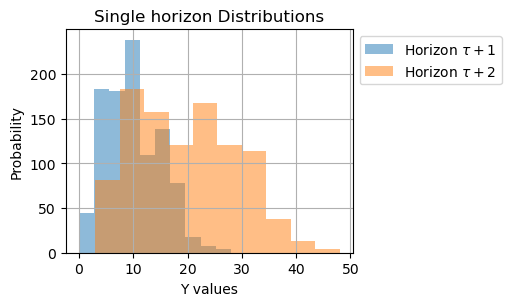

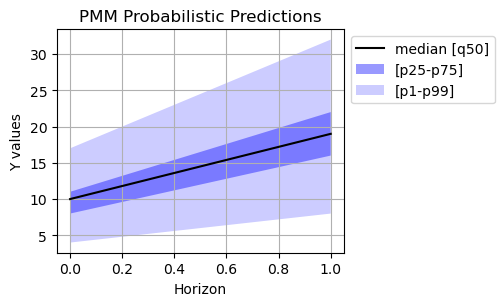

In [ ]:
#| hide
# Create single mixture and broadcast to N,H,1,K
weights = torch.ones((1,3))[None, :, :].unsqueeze(2)
lambdas = torch.Tensor([[5,10,15], [10,20,30]])[None, :, :].unsqueeze(2)

# Create repetitions for the batch dimension N.
N=2
weights = torch.repeat_interleave(input=weights, repeats=N, dim=0)
lambdas = torch.repeat_interleave(input=lambdas, repeats=N, dim=0)

print('weights.shape (N,H,1,K) \t', weights.shape)
print('lambdas.shape (N,H,1, K) \t', lambdas.shape)

distr = PMM(quantiles=[0.1, 0.40, 0.5, 0.60, 0.9], weighted=True)
weights = torch.ones_like(lambdas)
distr_args = (lambdas, weights)
samples, sample_mean, quants = distr.sample(distr_args)

print('samples.shape (N,H,1,num_samples) ', samples.shape)
print('sample_mean.shape (N,H,1,1) ', sample_mean.shape)
print('quants.shape  (N,H,1,Q) \t\t', quants.shape)

# Plot synthethic data
x_plot = range(quants.shape[1]) # H length
y_plot_hat = quants[0,:,0,:]  # Filter N,G,T -> H,Q
samples_hat = samples[0,:,0,:]  # Filter N,G,T -> H,num_samples

# Kernel density plot for single forecast horizon \tau = t+1
fig, ax = plt.subplots(figsize=(3.7, 2.9))

ax.hist(samples_hat[0,:], alpha=0.5, label=r'Horizon $\tau+1$')
ax.hist(samples_hat[1,:], alpha=0.5, label=r'Horizon $\tau+2$')
ax.set(xlabel='Y values', ylabel='Probability')
plt.title('Single horizon Distributions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

# Plot simulated trajectory
fig, ax = plt.subplots(figsize=(3.7, 2.9))
plt.plot(x_plot, y_plot_hat[:,2], color='black', label='median [q50]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,1], y2=y_plot_hat[:,3],
                 facecolor='blue', alpha=0.4, label='[p25-p75]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,0], y2=y_plot_hat[:,4],
                 facecolor='blue', alpha=0.2, label='[p1-p99]')
ax.set(xlabel='Horizon', ylabel='Y values')
plt.title('PMM Probabilistic Predictions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

## Gaussian Mixture Mesh (GMM)

In [ ]:
#| export
class GMM(torch.nn.Module):
    """ Gaussian Mixture Mesh

    This Gaussian Mixture statistical model assumes independence across groups of 
    data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

    $$ \mathrm{P}\\left(\mathbf{y}_{[b][t+1:t+H]}\\right) = 
    \prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P}\left(\mathbf{y}_{[g_{i}][\\tau]}\\right)=
    \prod_{\\beta\in[g_{i}]}
    \\left(\sum_{k=1}^{K} w_k \prod_{(\\beta,\\tau) \in [g_i][t+1:t+H]} 
    \mathrm{Gaussian}(y_{\\beta,\\tau}, \hat{\mu}_{\\beta,\\tau,k}, \sigma_{\\beta,\\tau,k})\\right)$$

    **Parameters:**<br>
    `n_components`: int=10, the number of mixture components.<br>
    `level`: float list [0,100], confidence levels for prediction intervals.<br>
    `quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
    `return_params`: bool=False, wether or not return the Distribution parameters.<br>
    `batch_correlation`: bool=False, wether or not model batch correlations.<br>
    `horizon_correlation`: bool=False, wether or not model horizon correlations.<br><br>

    **References:**<br>
    [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
    Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
    Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
    """
    def __init__(self, n_components=1, level=[80, 90], quantiles=None, 
                 num_samples=1000, return_params=False,
                 batch_correlation=False, horizon_correlation=False,
                 weighted=False):
        super(GMM, self).__init__()
        # Transform level to MQLoss parameters
        qs, self.output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            qs = torch.Tensor(quantiles)
        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.num_samples = num_samples
        self.batch_correlation = batch_correlation
        self.horizon_correlation = horizon_correlation     
        self.weighted = weighted   

        # If True, predict_step will return Distribution's parameters
        self.return_params = return_params

        mu_names = [f"-mu-{i}" for i in range(1, n_components + 1)]
        std_names = [f"-std-{i}" for i in range(1, n_components + 1)]
        if weighted:
            weight_names = [f"-weight-{i}" for i in range(1, n_components + 1)]
            self.param_names = [
            i for j in zip(mu_names, std_names, weight_names) for i in j
        ]
        else:
            self.param_names = [i for j in zip(mu_names, std_names) for i in j]

        if self.return_params:
            self.output_names = self.output_names + self.param_names

        # Add first output entry for the sample_mean
        self.output_names.insert(0, "")

        self.n_outputs = 2 + weighted
        self.n_components = n_components
        self.outputsize_multiplier = self.n_outputs * n_components
        self.is_distribution_output = True
        self.has_predicted = False

    def domain_map(self, output: torch.Tensor):
        output = output.reshape(output.shape[0],
                                output.shape[1],
                               -1,
                               self.outputsize_multiplier)
        
        return torch.tensor_split(output, self.n_outputs, dim=-1)

    def scale_decouple(self, 
                       output,
                       loc: Optional[torch.Tensor] = None,
                       scale: Optional[torch.Tensor] = None,
                       eps: float=0.2):
        """ Scale Decouple

        Stabilizes model's output optimization, by learning residual
        variance and residual location based on anchoring `loc`, `scale`.
        Also adds domain protection to the distribution parameters.
        """
        if self.weighted:
            means, stds, weights = output
            weights = F.softmax(weights, dim=-1)
        else:
            means, stds = output
            
        stds = F.softplus(stds)
        if (loc is not None) and (scale is not None):
            if loc.ndim == 3:
                loc = loc.unsqueeze(-1)
                scale = scale.unsqueeze(-1)
            means = (means * scale) + loc
            stds = (stds + eps) * scale
        
        if self.weighted:
            return (means, stds, weights)
        else:
            return (means, stds)

    def get_distribution(self, distr_args) -> Distribution:
        """
        Construct the associated Pytorch Distribution, given the collection of
        constructor arguments and, optionally, location and scale tensors.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>

        **Returns**<br>
        `Distribution`: AffineTransformed distribution.<br>
        """
        if self.weighted:
            means, stds, weights = distr_args
        else:
            means, stds = distr_args
            weights = torch.full_like(means, fill_value=1 / self.n_components)
            
        mix = Categorical(weights)
        components = Normal(loc=means, scale=stds)
        distr = MixtureSameFamily(mixture_distribution=mix,
                                      component_distribution=components)    

        self.distr_mean = distr.mean
        
        return distr

    def sample(self,
               distr_args: torch.Tensor,
               num_samples: Optional[int] = None):
        """
        Construct the empirical quantiles from the estimated Distribution,
        sampling from it `num_samples` independently.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `num_samples`: int, overwrite number of samples for the empirical quantiles.<br>

        **Returns**<br>
        `samples`: tensor, shape [B,H,`num_samples`].<br>
        `quantiles`: tensor, empirical quantiles defined by `levels`.<br>
        """
        if num_samples is None:
            num_samples = self.num_samples

        # Instantiate Scaled Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args)
        samples = distr.sample(sample_shape=(num_samples,))
        samples = samples.permute(1, 2, 3, 0)                  # [samples, B, H, N] -> [B, H, N, samples]

        sample_mean = torch.mean(samples, dim=-1, keepdim=True) 

        # Compute quantiles
        quantiles_device = self.quantiles.to(distr_args[0].device)
        quants = torch.quantile(input=samples, 
                                q=quantiles_device, 
                                dim=-1)
        quants = quants.permute(1, 2, 3, 0) # [Q, B, H, N] -> [B, H, N, Q]

        return samples, sample_mean, quants
    
    def update_quantile(self, q: Optional[List[float]] = None):
        if q is not None:
          self.quantiles = nn.Parameter(torch.tensor(q, dtype=torch.float32), requires_grad=False)
          self.output_names = [""] + [f"_ql{q_i}" for q_i in q] + self.return_params * self.param_names
          self.has_predicted = True
        elif q is None and self.has_predicted:
          self.quantiles = nn.Parameter(torch.tensor([0.5], dtype=torch.float32), requires_grad=False)          
          self.output_names = ["", "-median"] + self.return_params * self.param_names

    def __call__(self,
                 y: torch.Tensor,
                 distr_args: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):
        """
        Computes the negative log-likelihood objective function. 
        To estimate the following predictive distribution:

        $$\mathrm{P}(\mathbf{y}_{\\tau}\,|\,\\theta) \\quad \mathrm{and} \\quad -\log(\mathrm{P}(\mathbf{y}_{\\tau}\,|\,\\theta))$$

        where $\\theta$ represents the distributions parameters. It aditionally 
        summarizes the objective signal using a weighted average using the `mask` tensor. 

        **Parameters**<br>
        `y`: tensor, Actual values.<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns**<br>
        `loss`: scalar, weighted loss function against which backpropagation will be performed.<br>
        """
        # Instantiate Scaled Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args)
        x = distr._pad(y)
        log_prob_x = distr.component_distribution.log_prob(x)
        log_mix_prob = torch.log_softmax(distr.mixture_distribution.logits, dim=-1)
        if self.batch_correlation:
                log_prob_x = torch.sum(log_prob_x, dim=0, keepdim=True)
        if self.horizon_correlation:
                log_prob_x = torch.sum(log_prob_x, dim=1, keepdim=True)
        loss_values = -torch.logsumexp(log_prob_x + log_mix_prob, dim=-1)  
       
        return weighted_average(loss_values, weights=mask)

In [ ]:
show_doc(GMM, name='GMM.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2248){target="_blank" style="float:right; font-size:smaller"}

### GMM.__init__

>      GMM.__init__ (n_components=1, level=[80, 90], quantiles=None,
>                    num_samples=1000, return_params=False,
>                    batch_correlation=False, horizon_correlation=False,
>                    weighted=False)

*Gaussian Mixture Mesh

This Gaussian Mixture statistical model assumes independence across groups of 
data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

$$ \mathrm{P}\left(\mathbf{y}_{[b][t+1:t+H]}\right) = 
\prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P}\left(\mathbf{y}_{[g_{i}][\tau]}\right)=
\prod_{\beta\in[g_{i}]}
\left(\sum_{k=1}^{K} w_k \prod_{(\beta,\tau) \in [g_i][t+1:t+H]} 
\mathrm{Gaussian}(y_{\beta,\tau}, \hat{\mu}_{\beta,\tau,k}, \sigma_{\beta,\tau,k})\right)$$

**Parameters:**<br>
`n_components`: int=10, the number of mixture components.<br>
`level`: float list [0,100], confidence levels for prediction intervals.<br>
`quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
`return_params`: bool=False, wether or not return the Distribution parameters.<br>
`batch_correlation`: bool=False, wether or not model batch correlations.<br>
`horizon_correlation`: bool=False, wether or not model horizon correlations.<br><br>

**References:**<br>
[Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)*

In [ ]:
show_doc(GMM.sample, name='GMM.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2338){target="_blank" style="float:right; font-size:smaller"}

### GMM.sample

>      GMM.sample (distr_args:torch.Tensor, num_samples:Optional[int]=None)

*Construct the empirical quantiles from the estimated Distribution,
sampling from it `num_samples` independently.

**Parameters**<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`num_samples`: int, overwrite number of samples for the empirical quantiles.<br>

**Returns**<br>
`samples`: tensor, shape [B,H,`num_samples`].<br>
`quantiles`: tensor, empirical quantiles defined by `levels`.<br>*

In [ ]:
show_doc(GMM.__call__, name='GMM.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2445){target="_blank" style="float:right; font-size:smaller"}

### GMM.__call__

>      GMM.__call__ (y:torch.Tensor, distr_args:torch.Tensor,
>                    mask:Optional[torch.Tensor]=None)

*Computes the negative log-likelihood objective function. 
To estimate the following predictive distribution:

$$\mathrm{P}(\mathbf{y}_{\tau}\,|\,\theta) \quad \mathrm{and} \quad -\log(\mathrm{P}(\mathbf{y}_{\tau}\,|\,\theta))$$

where $\theta$ represents the distributions parameters. It aditionally 
summarizes the objective signal using a weighted average using the `mask` tensor. 

**Parameters**<br>
`y`: tensor, Actual values.<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns**<br>
`loss`: scalar, weighted loss function against which backpropagation will be performed.<br>*

![](imgs_losses/gmm.png)

In [ ]:
# | hide
# Unit tests to check PMM's stored quantiles
# attribute is correctly instantiated
check = GMM(n_components=2, level=[80, 90])
test_eq(len(check.quantiles), 5)

check = GMM(n_components=2, 
            quantiles=[0.0100, 0.1000, 0.5, 0.9000, 0.9900])
print(check.output_names)
print(check.quantiles)
test_eq(len(check.quantiles), 5)

check = GMM(n_components=2,
            quantiles=[0.0100, 0.1000, 0.9000, 0.9900])
test_eq(len(check.quantiles), 4)

['', '-lo-98.0', '-lo-80.0', '-median', '-hi-80.0', '-hi-98.0']
Parameter containing:
tensor([0.0100, 0.1000, 0.5000, 0.9000, 0.9900])


weights.shape (N,H,1,K) 	 torch.Size([2, 2, 1, 3])
means.shape (N,H,1,K) 	 torch.Size([2, 2, 1, 3])
stds.shape (N,H,1,K) 	 torch.Size([2, 2, 1, 3])
samples.shape (N,H,1,num_samples)  torch.Size([2, 2, 1, 1000])
sample_mean.shape (N,H,1,1)  torch.Size([2, 2, 1, 1])
quants.shape  (N,H,1, Q) 		 torch.Size([2, 2, 1, 5])


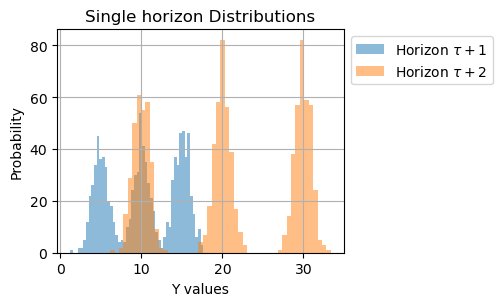

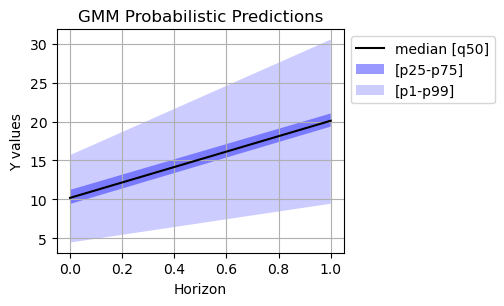

In [ ]:
#| hide
# Create single mixture and broadcast to N,H,1,K
means   = torch.Tensor([[5,10,15], [10,20,30]])[None, :, :].unsqueeze(2)

# # Create repetitions for the batch dimension N.
N=2
means = torch.repeat_interleave(input=means, repeats=N, dim=0)
weights = torch.ones_like(means)
stds  = torch.ones_like(means)

print('weights.shape (N,H,1,K) \t', weights.shape)
print('means.shape (N,H,1,K) \t', means.shape)
print('stds.shape (N,H,1,K) \t', stds.shape)

distr = GMM(quantiles=[0.1, 0.40, 0.5, 0.60, 0.9], weighted=True)
distr_args = (means, stds, weights)
samples, sample_mean, quants = distr.sample(distr_args)

print('samples.shape (N,H,1,num_samples) ', samples.shape)
print('sample_mean.shape (N,H,1,1) ', sample_mean.shape)
print('quants.shape  (N,H,1, Q) \t\t', quants.shape)

# Plot synthethic data
x_plot = range(quants.shape[1]) # H length
y_plot_hat = quants[0,:,0,:]  # Filter N,G,T -> H,Q
samples_hat = samples[0,:,0,:]  # Filter N,G,T -> H,num_samples

# Kernel density plot for single forecast horizon \tau = t+1
fig, ax = plt.subplots(figsize=(3.7, 2.9))

ax.hist(samples_hat[0,:], alpha=0.5, bins=50,
        label=r'Horizon $\tau+1$')
ax.hist(samples_hat[1,:], alpha=0.5, bins=50,
        label=r'Horizon $\tau+2$')
ax.set(xlabel='Y values', ylabel='Probability')
plt.title('Single horizon Distributions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

# Plot simulated trajectory
fig, ax = plt.subplots(figsize=(3.7, 2.9))
plt.plot(x_plot, y_plot_hat[:,2], color='black', label='median [q50]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,1], y2=y_plot_hat[:,3],
                 facecolor='blue', alpha=0.4, label='[p25-p75]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,0], y2=y_plot_hat[:,4],
                 facecolor='blue', alpha=0.2, label='[p1-p99]')
ax.set(xlabel='Horizon', ylabel='Y values')
plt.title('GMM Probabilistic Predictions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

## Negative Binomial Mixture Mesh (NBMM)

In [ ]:
#| export
class NBMM(torch.nn.Module):
    """ Negative Binomial Mixture Mesh

    This N. Binomial Mixture statistical model assumes independence across groups of 
    data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

    $$ \mathrm{P}\\left(\mathbf{y}_{[b][t+1:t+H]}\\right) = 
    \prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P}\left(\mathbf{y}_{[g_{i}][\\tau]}\\right)=
    \prod_{\\beta\in[g_{i}]}
    \\left(\sum_{k=1}^{K} w_k \prod_{(\\beta,\\tau) \in [g_i][t+1:t+H]} 
    \mathrm{NBinomial}(y_{\\beta,\\tau}, \hat{r}_{\\beta,\\tau,k}, \hat{p}_{\\beta,\\tau,k})\\right)$$

    **Parameters:**<br>
    `n_components`: int=10, the number of mixture components.<br>
    `level`: float list [0,100], confidence levels for prediction intervals.<br>
    `quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
    `return_params`: bool=False, wether or not return the Distribution parameters.<br><br>

    **References:**<br>
    [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
    Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
    Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
    """
    def __init__(self, n_components=1, level=[80, 90], quantiles=None, 
                 num_samples=1000, return_params=False, weighted=False):
        super(NBMM, self).__init__()
        # Transform level to MQLoss parameters
        qs, self.output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            qs = torch.Tensor(quantiles)
        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.num_samples = num_samples
        self.weighted = weighted   

        # If True, predict_step will return Distribution's parameters
        self.return_params = return_params

        total_count_names = [f"-total_count-{i}" for i in range(1, n_components + 1)]
        probs_names = [f"-probs-{i}" for i in range(1, n_components + 1)]
        if weighted:
            weight_names = [f"-weight-{i}" for i in range(1, n_components + 1)]
            self.param_names = [
            i for j in zip(total_count_names, probs_names, weight_names) for i in j
        ]
        else:
            self.param_names = [i for j in zip(total_count_names, probs_names) for i in j]

        if self.return_params:
            self.output_names = self.output_names + self.param_names

        # Add first output entry for the sample_mean
        self.output_names.insert(0, "")            

        self.n_outputs = 2 + weighted
        self.n_components = n_components
        self.outputsize_multiplier = self.n_outputs * n_components
        self.is_distribution_output = True
        self.has_predicted = False

    def domain_map(self, output: torch.Tensor):
        output = output.reshape(output.shape[0],
                                output.shape[1],
                               -1,
                               self.outputsize_multiplier)
        
        return torch.tensor_split(output, self.n_outputs, dim=-1)

    def scale_decouple(self, 
                       output,
                       loc: Optional[torch.Tensor] = None,
                       scale: Optional[torch.Tensor] = None,
                       eps: float=0.2):
        """ Scale Decouple

        Stabilizes model's output optimization, by learning residual
        variance and residual location based on anchoring `loc`, `scale`.
        Also adds domain protection to the distribution parameters.
        """
        # Efficient NBinomial parametrization
        if self.weighted:
            mu, alpha, weights = output
            weights = F.softmax(weights, dim=-1)
        else:
            mu, alpha = output

        mu = F.softplus(mu) + 1e-8
        alpha = F.softplus(alpha) + 1e-8    # alpha = 1/total_counts
        if (loc is not None) and (scale is not None):
            if loc.ndim == 3:
                loc = loc.unsqueeze(-1)
                scale = scale.unsqueeze(-1)           
            mu *= loc
            alpha /= (loc + 1.)

        # mu = total_count * (probs/(1-probs))
        # => probs = mu / (total_count + mu)
        # => probs = mu / [total_count * (1 + mu * (1/total_count))]
        total_count = 1.0 / alpha
        probs = (mu * alpha / (1.0 + mu * alpha)) + 1e-8 
        if self.weighted:
            return (total_count, probs, weights)
        else:
            return (total_count, probs)

    def get_distribution(self, distr_args) -> Distribution:
        """
        Construct the associated Pytorch Distribution, given the collection of
        constructor arguments and, optionally, location and scale tensors.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>

        **Returns**<br>
        `Distribution`: AffineTransformed distribution.<br>
        """
        if self.weighted:
            total_count, probs, weights = distr_args
        else:
            total_count, probs = distr_args
            weights = torch.full_like(total_count, fill_value=1 / self.n_components)

        mix = Categorical(weights)
        components = NegativeBinomial(total_count, probs)
        components.support = constraints.nonnegative
        distr = MixtureSameFamily(mixture_distribution=mix,
                                      component_distribution=components)    

        self.distr_mean = distr.mean
        
        return distr

    def sample(self,
               distr_args: torch.Tensor,
               num_samples: Optional[int] = None):
        """
        Construct the empirical quantiles from the estimated Distribution,
        sampling from it `num_samples` independently.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `num_samples`: int, overwrite number of samples for the empirical quantiles.<br>

        **Returns**<br>
        `samples`: tensor, shape [B,H,`num_samples`].<br>
        `quantiles`: tensor, empirical quantiles defined by `levels`.<br>
        """
        if num_samples is None:
            num_samples = self.num_samples

        # Instantiate Scaled Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args)
        samples = distr.sample(sample_shape=(num_samples,))
        samples = samples.permute(1, 2, 3, 0)                  # [samples, B, H, N] -> [B, H, N, samples]

        sample_mean = torch.mean(samples, dim=-1, keepdim=True) 

        # Compute quantiles
        quantiles_device = self.quantiles.to(distr_args[0].device)
        quants = torch.quantile(input=samples, 
                                q=quantiles_device, 
                                dim=-1)
        quants = quants.permute(1, 2, 3, 0) # [Q, B, H, N] -> [B, H, N, Q]

        return samples, sample_mean, quants

    def update_quantile(self, q: Optional[List[float]] = None):
        if q is not None:
          self.quantiles = nn.Parameter(torch.tensor(q, dtype=torch.float32), requires_grad=False)
          self.output_names = [""] + [f"_ql{q_i}" for q_i in q] + self.return_params * self.param_names
          self.has_predicted = True
        elif q is None and self.has_predicted:
          self.quantiles = nn.Parameter(torch.tensor([0.5], dtype=torch.float32), requires_grad=False)
          self.output_names = ["", "-median"] + self.return_params * self.param_names

    def __call__(self,
                 y: torch.Tensor,
                 distr_args: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):
        """
        Computes the negative log-likelihood objective function. 
        To estimate the following predictive distribution:

        $$\mathrm{P}(\mathbf{y}_{\\tau}\,|\,\\theta) \\quad \mathrm{and} \\quad -\log(\mathrm{P}(\mathbf{y}_{\\tau}\,|\,\\theta))$$

        where $\\theta$ represents the distributions parameters. It aditionally 
        summarizes the objective signal using a weighted average using the `mask` tensor. 

        **Parameters**<br>
        `y`: tensor, Actual values.<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns**<br>
        `loss`: scalar, weighted loss function against which backpropagation will be performed.<br>
        """
        # Instantiate Scaled Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args)
        loss_values = -distr.log_prob(y)
        loss_weights = mask
       
        return weighted_average(loss_values, weights=loss_weights)

In [ ]:
show_doc(NBMM, name='NBMM.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2455){target="_blank" style="float:right; font-size:smaller"}

### NBMM.__init__

>      NBMM.__init__ (n_components=1, level=[80, 90], quantiles=None,
>                     num_samples=1000, return_params=False, weighted=False)

*Negative Binomial Mixture Mesh

This N. Binomial Mixture statistical model assumes independence across groups of 
data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

$$ \mathrm{P}\left(\mathbf{y}_{[b][t+1:t+H]}\right) = 
\prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P}\left(\mathbf{y}_{[g_{i}][\tau]}\right)=
\prod_{\beta\in[g_{i}]}
\left(\sum_{k=1}^{K} w_k \prod_{(\beta,\tau) \in [g_i][t+1:t+H]} 
\mathrm{NBinomial}(y_{\beta,\tau}, \hat{r}_{\beta,\tau,k}, \hat{p}_{\beta,\tau,k})\right)$$

**Parameters:**<br>
`n_components`: int=10, the number of mixture components.<br>
`level`: float list [0,100], confidence levels for prediction intervals.<br>
`quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
`return_params`: bool=False, wether or not return the Distribution parameters.<br><br>

**References:**<br>
[Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)*

In [ ]:
show_doc(NBMM.sample, name='NBMM.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2548){target="_blank" style="float:right; font-size:smaller"}

### NBMM.sample

>      NBMM.sample (distr_args:torch.Tensor, num_samples:Optional[int]=None)

*Construct the empirical quantiles from the estimated Distribution,
sampling from it `num_samples` independently.

**Parameters**<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`num_samples`: int, overwrite number of samples for the empirical quantiles.<br>

**Returns**<br>
`samples`: tensor, shape [B,H,`num_samples`].<br>
`quantiles`: tensor, empirical quantiles defined by `levels`.<br>*

In [ ]:
show_doc(NBMM.__call__, name='NBMM.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2659){target="_blank" style="float:right; font-size:smaller"}

### NBMM.__call__

>      NBMM.__call__ (y:torch.Tensor, distr_args:torch.Tensor,
>                     mask:Optional[torch.Tensor]=None)

*Computes the negative log-likelihood objective function. 
To estimate the following predictive distribution:

$$\mathrm{P}(\mathbf{y}_{\tau}\,|\,\theta) \quad \mathrm{and} \quad -\log(\mathrm{P}(\mathbf{y}_{\tau}\,|\,\theta))$$

where $\theta$ represents the distributions parameters. It aditionally 
summarizes the objective signal using a weighted average using the `mask` tensor. 

**Parameters**<br>
`y`: tensor, Actual values.<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns**<br>
`loss`: scalar, weighted loss function against which backpropagation will be performed.<br>*

weights.shape (N,H,1,K) 	 torch.Size([2, 2, 1, 3])
counts.shape (N,H,1,K) 	 torch.Size([2, 2, 1, 3])
probs.shape (N,H,1,K) 	 torch.Size([2, 2, 1, 3])
samples.shape (N,H,1,num_samples)  torch.Size([2, 2, 1, 2000])
sample_mean.shape (N,H,1,1)  torch.Size([2, 2, 1, 1])
quants.shape  (N,H,1,Q) 		 torch.Size([2, 2, 1, 5])


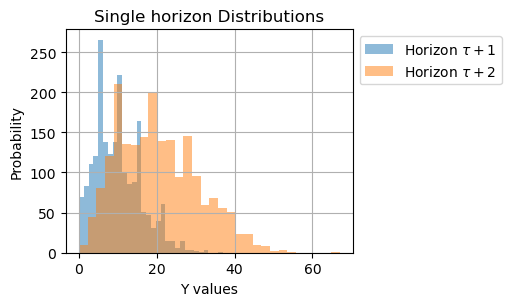

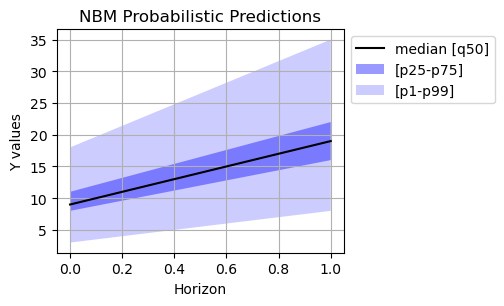

In [ ]:
#| hide
# Create single mixture and broadcast to N,H,1,K
counts   = torch.Tensor([[5,10,15], [10,20,30]])[None, :, :].unsqueeze(2)

# # Create repetitions for the batch dimension N.
N=2
counts = torch.repeat_interleave(input=counts, repeats=N, dim=0)
weights = torch.ones_like(counts)
probs  = torch.ones_like(counts) * 0.5

print('weights.shape (N,H,1,K) \t', weights.shape)
print('counts.shape (N,H,1,K) \t', counts.shape)
print('probs.shape (N,H,1,K) \t', probs.shape)

model = NBMM(quantiles=[0.1, 0.40, 0.5, 0.60, 0.9], weighted=True)
distr_args = (counts, probs, weights)
samples, sample_mean, quants = model.sample(distr_args, num_samples=2000)

print('samples.shape (N,H,1,num_samples) ', samples.shape)
print('sample_mean.shape (N,H,1,1) ', sample_mean.shape)
print('quants.shape  (N,H,1,Q) \t\t', quants.shape)

# Plot synthethic data
x_plot = range(quants.shape[1]) # H length
y_plot_hat = quants[0,:,0,:]  # Filter N,G,T -> H,Q
samples_hat = samples[0,:,0,:]  # Filter N,G,T -> H,num_samples

# Kernel density plot for single forecast horizon \tau = t+1
fig, ax = plt.subplots(figsize=(3.7, 2.9))

ax.hist(samples_hat[0,:], alpha=0.5, bins=30,
        label=r'Horizon $\tau+1$')
ax.hist(samples_hat[1,:], alpha=0.5, bins=30,
        label=r'Horizon $\tau+2$')
ax.set(xlabel='Y values', ylabel='Probability')
plt.title('Single horizon Distributions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

# Plot simulated trajectory
fig, ax = plt.subplots(figsize=(3.7, 2.9))
plt.plot(x_plot, y_plot_hat[:,2], color='black', label='median [q50]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,1], y2=y_plot_hat[:,3],
                 facecolor='blue', alpha=0.4, label='[p25-p75]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,0], y2=y_plot_hat[:,4],
                 facecolor='blue', alpha=0.2, label='[p1-p99]')
ax.set(xlabel='Horizon', ylabel='Y values')
plt.title('NBM Probabilistic Predictions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

# 5. Robustified Errors

This type of errors from robust statistic focus on methods resistant to outliers and violations of assumptions, providing reliable estimates and inferences. Robust estimators are used to reduce the impact of outliers, offering more stable results.

## Huber Loss

In [ ]:
#| export
class HuberLoss(BasePointLoss):
    """ Huber Loss

    The Huber loss, employed in robust regression, is a loss function that 
    exhibits reduced sensitivity to outliers in data when compared to the 
    squared error loss. This function is also refered as SmoothL1.

    The Huber loss function is quadratic for small errors and linear for large 
    errors, with equal values and slopes of the different sections at the two 
    points where $(y_{\\tau}-\hat{y}_{\\tau})^{2}$=$|y_{\\tau}-\hat{y}_{\\tau}|$.

    $$ L_{\delta}(y_{\\tau},\; \hat{y}_{\\tau})
    =\\begin{cases}{\\frac{1}{2}}(y_{\\tau}-\hat{y}_{\\tau})^{2}\;{\\text{for }}|y_{\\tau}-\hat{y}_{\\tau}|\leq \delta \\\ 
    \\delta \ \cdot \left(|y_{\\tau}-\hat{y}_{\\tau}|-{\\frac {1}{2}}\delta \\right),\;{\\text{otherwise.}}\end{cases}$$

    where $\\delta$ is a threshold parameter that determines the point at which the loss transitions from quadratic to linear,
    and can be tuned to control the trade-off between robustness and accuracy in the predictions.

    **Parameters:**<br>
    `delta`: float=1.0, Specifies the threshold at which to change between delta-scaled L1 and L2 loss.
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>
    
    **References:**<br>
    [Huber Peter, J (1964). "Robust Estimation of a Location Parameter". Annals of Statistics](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full)
    """   
    def __init__(self, delta: float=1., horizon_weight=None):
        super(HuberLoss, self).__init__(horizon_weight=horizon_weight,
                                  outputsize_multiplier=1,
                                  output_names=[''])
        self.delta = delta

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `huber_loss`: tensor (single value).
        """
        losses = F.huber_loss(y, y_hat, reduction='none', delta=self.delta)        
        weights = self._compute_weights(y=y, mask=mask)
        return _weighted_mean(losses=losses, weights=weights)

In [ ]:
show_doc(HuberLoss, name='HuberLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2669){target="_blank" style="float:right; font-size:smaller"}

### HuberLoss.__init__

>      HuberLoss.__init__ (delta:float=1.0, horizon_weight=None)

*Huber Loss

The Huber loss, employed in robust regression, is a loss function that 
exhibits reduced sensitivity to outliers in data when compared to the 
squared error loss. This function is also refered as SmoothL1.

The Huber loss function is quadratic for small errors and linear for large 
errors, with equal values and slopes of the different sections at the two 
points where $(y_{\tau}-\hat{y}_{\tau})^{2}$=$|y_{\tau}-\hat{y}_{\tau}|$.

$$ L_{\delta}(y_{\tau},\; \hat{y}_{\tau})
=\begin{cases}{\frac{1}{2}}(y_{\tau}-\hat{y}_{\tau})^{2}\;{\text{for }}|y_{\tau}-\hat{y}_{\tau}|\leq \delta \\ 
\delta \ \cdot \left(|y_{\tau}-\hat{y}_{\tau}|-{\frac {1}{2}}\delta \right),\;{\text{otherwise.}}\end{cases}$$

where $\delta$ is a threshold parameter that determines the point at which the loss transitions from quadratic to linear,
and can be tuned to control the trade-off between robustness and accuracy in the predictions.

**Parameters:**<br>
`delta`: float=1.0, Specifies the threshold at which to change between delta-scaled L1 and L2 loss.
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

**References:**<br>
[Huber Peter, J (1964). "Robust Estimation of a Location Parameter". Annals of Statistics](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full)*

In [ ]:
show_doc(HuberLoss.__call__, name='HuberLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2701){target="_blank" style="float:right; font-size:smaller"}

### HuberLoss.__call__

>      HuberLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                          y_insample:torch.Tensor,
>                          mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`huber_loss`: tensor (single value).*

![](imgs_losses/huber_loss.png)

## Tukey Loss

In [ ]:
#| export
class TukeyLoss(BasePointLoss):
    """ Tukey Loss

    The Tukey loss function, also known as Tukey's biweight function, is a 
    robust statistical loss function used in robust statistics. Tukey's loss exhibits
    quadratic behavior near the origin, like the Huber loss; however, it is even more
    robust to outliers as the loss for large residuals remains constant instead of 
    scaling linearly.

    The parameter $c$ in Tukey's loss determines the ''saturation'' point
    of the function: Higher values of $c$ enhance sensitivity, while lower values 
    increase resistance to outliers.

    $$ L_{c}(y_{\\tau},\; \hat{y}_{\\tau})
    =\\begin{cases}{
    \\frac{c^{2}}{6}} \\left[1-(\\frac{y_{\\tau}-\hat{y}_{\\tau}}{c})^{2} \\right]^{3}    \;\\text{for } |y_{\\tau}-\hat{y}_{\\tau}|\leq c \\\ 
    \\frac{c^{2}}{6} \qquad \\text{otherwise.}  \end{cases}$$

    Please note that the Tukey loss function assumes the data to be stationary or
    normalized beforehand. If the error values are excessively large, the algorithm
    may need help to converge during optimization. It is advisable to employ small learning rates.

    **Parameters:**<br>
    `c`: float=4.685, Specifies the Tukey loss' threshold on which residuals are no longer considered.<br>
    `normalize`: bool=True, Wether normalization is performed within Tukey loss' computation.<br>

    **References:**<br>
    [Beaton, A. E., and Tukey, J. W. (1974). "The Fitting of Power Series, Meaning Polynomials, Illustrated on Band-Spectroscopic Data."](https://www.jstor.org/stable/1267936)
    """
    def __init__(self, c: float=4.685, normalize: bool=True):
        super(TukeyLoss, self).__init__()
        self.outputsize_multiplier = 1
        self.c = c
        self.normalize = normalize
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Input:
        Univariate: [B, H, 1]
        Multivariate: [B, H, N]

        Output: [B, H, N]
        """

        return y_hat

    def masked_mean(self, x, mask, dim):
        x_nan = x.masked_fill(mask < 1, float("nan"))
        x_mean = x_nan.nanmean(dim=dim, keepdim=True)
        x_mean = torch.nan_to_num(x_mean, nan=0.0)
        return x_mean

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `tukey_loss`: tensor (single value).
        """
        if mask is None:
            mask = torch.ones_like(y_hat)

        # We normalize the Tukey loss, to satisfy 4.685 normal outlier bounds
        if self.normalize:
            y_mean = self.masked_mean(x=y, mask=mask, dim=-1)
            y_std = torch.sqrt(self.masked_mean(x=(y - y_mean) ** 2, mask=mask, dim=-1)) + 1e-2
        else:
            y_std = 1.
        delta_y = torch.abs(y - y_hat) / y_std

        tukey_mask = torch.greater_equal(self.c * torch.ones_like(delta_y), delta_y)
        tukey_loss = tukey_mask * mask * (1-(delta_y/(self.c))**2)**3 + (1-(tukey_mask * 1))
        tukey_loss = (self.c**2 / 6) * torch.mean(tukey_loss)
        return tukey_loss

In [ ]:
show_doc(TukeyLoss, name='TukeyLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2721){target="_blank" style="float:right; font-size:smaller"}

### TukeyLoss.__init__

>      TukeyLoss.__init__ (c:float=4.685, normalize:bool=True)

*Tukey Loss

The Tukey loss function, also known as Tukey's biweight function, is a 
robust statistical loss function used in robust statistics. Tukey's loss exhibits
quadratic behavior near the origin, like the Huber loss; however, it is even more
robust to outliers as the loss for large residuals remains constant instead of 
scaling linearly.

The parameter $c$ in Tukey's loss determines the ''saturation'' point
of the function: Higher values of $c$ enhance sensitivity, while lower values 
increase resistance to outliers.

$$ L_{c}(y_{\tau},\; \hat{y}_{\tau})
=\begin{cases}{
\frac{c^{2}}{6}} \left[1-(\frac{y_{\tau}-\hat{y}_{\tau}}{c})^{2} \right]^{3}    \;\text{for } |y_{\tau}-\hat{y}_{\tau}|\leq c \\ 
\frac{c^{2}}{6} \qquad \text{otherwise.}  \end{cases}$$

Please note that the Tukey loss function assumes the data to be stationary or
normalized beforehand. If the error values are excessively large, the algorithm
may need help to converge during optimization. It is advisable to employ small learning rates.

**Parameters:**<br>
`c`: float=4.685, Specifies the Tukey loss' threshold on which residuals are no longer considered.<br>
`normalize`: bool=True, Wether normalization is performed within Tukey loss' computation.<br>

**References:**<br>
[Beaton, A. E., and Tukey, J. W. (1974). "The Fitting of Power Series, Meaning Polynomials, Illustrated on Band-Spectroscopic Data."](https://www.jstor.org/stable/1267936)*

In [ ]:
show_doc(TukeyLoss.__call__, name='TukeyLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2772){target="_blank" style="float:right; font-size:smaller"}

### TukeyLoss.__call__

>      TukeyLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                          y_insample:torch.Tensor,
>                          mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`tukey_loss`: tensor (single value).*

![](imgs_losses/tukey_loss.png)

## Huberized Quantile Loss

In [ ]:
#| export
class HuberQLoss(BasePointLoss):
    """ Huberized Quantile Loss

    The Huberized quantile loss is a modified version of the quantile loss function that
    combines the advantages of the quantile loss and the Huber loss. It is commonly used
    in regression tasks, especially when dealing with data that contains outliers or heavy tails.

    The Huberized quantile loss between `y` and `y_hat` measure the Huber Loss in a non-symmetric way.
    The loss pays more attention to under/over-estimation depending on the quantile parameter $q$; 
    and controls the trade-off between robustness and accuracy in the predictions with the parameter $delta$.

    $$ \mathrm{HuberQL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q)}_{\\tau}) = 
    (1-q)\, L_{\delta}(y_{\\tau},\; \hat{y}^{(q)}_{\\tau}) \mathbb{1}\{ \hat{y}^{(q)}_{\\tau} \geq y_{\\tau} \} + 
    q\, L_{\delta}(y_{\\tau},\; \hat{y}^{(q)}_{\\tau}) \mathbb{1}\{ \hat{y}^{(q)}_{\\tau} < y_{\\tau} \} $$

    **Parameters:**<br>
    `delta`: float=1.0, Specifies the threshold at which to change between delta-scaled L1 and L2 loss.<br>
    `q`: float, between 0 and 1. The slope of the quantile loss, in the context of quantile regression, the q determines the conditional quantile level.<br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

    **References:**<br>
    [Huber Peter, J (1964). "Robust Estimation of a Location Parameter". Annals of Statistics](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full)<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)
    """
    def __init__(self, q, delta: float=1., horizon_weight=None):
        super(HuberQLoss, self).__init__(horizon_weight=horizon_weight,
                                           outputsize_multiplier=1,
                                           output_names=[f'_q{q}_d{delta}'])
        self.q = q
        self.delta = delta

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies datapoints to consider in loss.<br>

        **Returns:**<br>
        `huber_qloss`: tensor (single value).
        """
        
        error  = y_hat - y
        zero_error = torch.zeros_like(error)
        sq     = torch.maximum(-error, zero_error)
        s1_q   = torch.maximum(error, zero_error)
        losses = self.q * F.huber_loss(sq, zero_error, 
                                       reduction='none', delta=self.delta) + \
                 (1 - self.q) * F.huber_loss(s1_q, zero_error, 
                                        reduction='none', delta=self.delta)

        weights = self._compute_weights(y=y, mask=mask)
        return _weighted_mean(losses=losses, weights=weights)

In [ ]:
show_doc(HuberQLoss, name='HuberQLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2809){target="_blank" style="float:right; font-size:smaller"}

### HuberQLoss.__init__

>      HuberQLoss.__init__ (q, delta:float=1.0, horizon_weight=None)

*Huberized Quantile Loss

The Huberized quantile loss is a modified version of the quantile loss function that
combines the advantages of the quantile loss and the Huber loss. It is commonly used
in regression tasks, especially when dealing with data that contains outliers or heavy tails.

The Huberized quantile loss between `y` and `y_hat` measure the Huber Loss in a non-symmetric way.
The loss pays more attention to under/over-estimation depending on the quantile parameter $q$; 
and controls the trade-off between robustness and accuracy in the predictions with the parameter $delta$.

$$ \mathrm{HuberQL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q)}_{\tau}) = 
(1-q)\, L_{\delta}(y_{\tau},\; \hat{y}^{(q)}_{\tau}) \mathbb{1}\{ \hat{y}^{(q)}_{\tau} \geq y_{\tau} \} + 
q\, L_{\delta}(y_{\tau},\; \hat{y}^{(q)}_{\tau}) \mathbb{1}\{ \hat{y}^{(q)}_{\tau} < y_{\tau} \} $$

**Parameters:**<br>
`delta`: float=1.0, Specifies the threshold at which to change between delta-scaled L1 and L2 loss.<br>
`q`: float, between 0 and 1. The slope of the quantile loss, in the context of quantile regression, the q determines the conditional quantile level.<br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>

**References:**<br>
[Huber Peter, J (1964). "Robust Estimation of a Location Parameter". Annals of Statistics](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full)<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)*

In [ ]:
show_doc(HuberQLoss.__call__, name='HuberQLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2843){target="_blank" style="float:right; font-size:smaller"}

### HuberQLoss.__call__

>      HuberQLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                           y_insample:torch.Tensor,
>                           mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies datapoints to consider in loss.<br>

**Returns:**<br>
`huber_qloss`: tensor (single value).*

![](imgs_losses/huber_qloss.png)

## Huberized MQLoss

In [ ]:
#| export
class HuberMQLoss(BasePointLoss):
    """  Huberized Multi-Quantile loss

    The Huberized Multi-Quantile loss (HuberMQL) is a modified version of the multi-quantile loss function 
    that combines the advantages of the quantile loss and the Huber loss. HuberMQL is commonly used in regression 
    tasks, especially when dealing with data that contains outliers or heavy tails. The loss function pays 
    more attention to under/over-estimation depending on the quantile list $[q_{1},q_{2},\dots]$ parameter. 
    It controls the trade-off between robustness and prediction accuracy with the parameter $\\delta$.

    $$ \mathrm{HuberMQL}_{\delta}(\\mathbf{y}_{\\tau},[\\mathbf{\hat{y}}^{(q_{1})}_{\\tau}, ... ,\hat{y}^{(q_{n})}_{\\tau}]) = 
    \\frac{1}{n} \\sum_{q_{i}} \mathrm{HuberQL}_{\\delta}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q_{i})}_{\\tau}) $$

    **Parameters:**<br>
    `level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
    `quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.
    `delta`: float=1.0, Specifies the threshold at which to change between delta-scaled L1 and L2 loss.<br>   
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br> 

    **References:**<br>
    [Huber Peter, J (1964). "Robust Estimation of a Location Parameter". Annals of Statistics](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full)<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)
    """
    def __init__(self, level=[80, 90], quantiles=None, delta: float=1.0, horizon_weight=None):

        qs, output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)
        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, output_names = quantiles_to_outputs(quantiles)
            qs = torch.Tensor(quantiles)

        super(HuberMQLoss, self).__init__(horizon_weight=horizon_weight,
                                     outputsize_multiplier=len(qs),
                                     output_names=output_names)
        
        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.delta = delta

    def domain_map(self, y_hat: torch.Tensor):
        """
        Input:
        Univariate: [B, H, 1 * Q]
        Multivariate: [B, H, N * Q]

        Output: [B, H, N, Q]
        """
        output = y_hat.reshape(y_hat.shape[0],
                               y_hat.shape[1],
                               -1,
                               self.outputsize_multiplier)

        return output
    
    def _compute_weights(self, y, mask):
        """
        Compute final weights for each datapoint (based on all weights and all masks)
        Set horizon_weight to a ones[H] tensor if not set.
        If set, check that it has the same length as the horizon in x.
        """

        if self.horizon_weight is None:
            weights = torch.ones_like(mask)
        else:
            assert mask.shape[1] == len(self.horizon_weight), \
                'horizon_weight must have same length as Y'       
            weights = self.horizon_weight.clone()
            weights = weights[None, :, None, None].to(mask.device)
            weights = torch.ones_like(mask, device=mask.device) * weights
        
        return weights * mask

    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `hmqloss`: tensor (single value).
        """
        # [B, h, N] -> [B, h, N, 1]
        if y_hat.ndim == 3:
            y_hat = y_hat.unsqueeze(-1)

        y = y.unsqueeze(-1)        
        if mask is not None:
            mask = mask.unsqueeze(-1)
        else:
            mask = torch.ones_like(y, device=y.device)
        
        error  = y_hat - y
        
        zero_error = torch.zeros_like(error)        
        sq     = torch.maximum(-error, torch.zeros_like(error))
        s1_q   = torch.maximum(error, torch.zeros_like(error))
        
        quantiles = self.quantiles[None, None, None, :]
        losses = F.huber_loss(quantiles * sq, zero_error, 
                                        reduction='none', delta=self.delta) + \
                  F.huber_loss((1 - quantiles) * s1_q, zero_error, 
                                reduction='none', delta=self.delta)
        losses = (1 / len(quantiles)) * losses

        weights = self._compute_weights(y=losses, mask=mask) 

        return _weighted_mean(losses=losses, weights=weights)

In [ ]:
show_doc(HuberMQLoss, name='HuberMQLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2872){target="_blank" style="float:right; font-size:smaller"}

### HuberMQLoss.__init__

>      HuberMQLoss.__init__ (level=[80, 90], quantiles=None, delta:float=1.0,
>                            horizon_weight=None)

*Huberized Multi-Quantile loss

The Huberized Multi-Quantile loss (HuberMQL) is a modified version of the multi-quantile loss function 
that combines the advantages of the quantile loss and the Huber loss. HuberMQL is commonly used in regression 
tasks, especially when dealing with data that contains outliers or heavy tails. The loss function pays 
more attention to under/over-estimation depending on the quantile list $[q_{1},q_{2},\dots]$ parameter. 
It controls the trade-off between robustness and prediction accuracy with the parameter $\delta$.

$$ \mathrm{HuberMQL}_{\delta}(\mathbf{y}_{\tau},[\mathbf{\hat{y}}^{(q_{1})}_{\tau}, ... ,\hat{y}^{(q_{n})}_{\tau}]) = 
\frac{1}{n} \sum_{q_{i}} \mathrm{HuberQL}_{\delta}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q_{i})}_{\tau}) $$

**Parameters:**<br>
`level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
`quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.
`delta`: float=1.0, Specifies the threshold at which to change between delta-scaled L1 and L2 loss.<br>   
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br> 

**References:**<br>
[Huber Peter, J (1964). "Robust Estimation of a Location Parameter". Annals of Statistics](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full)<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)*

In [ ]:
show_doc(HuberMQLoss.__call__, name='HuberMQLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2943){target="_blank" style="float:right; font-size:smaller"}

### HuberMQLoss.__call__

>      HuberMQLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                            y_insample:torch.Tensor,
>                            mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`hmqloss`: tensor (single value).*

![](imgs_losses/hmq_loss.png)

## Huberized IQLoss

In [ ]:
#| export
class HuberIQLoss(HuberQLoss):
    """Implicit Huber Quantile Loss

    Computes the huberized quantile loss between `y` and `y_hat`, with the quantile `q` provided as an input to the network. 
    HuberIQLoss measures the deviation of a huberized quantile forecast.
    By weighting the absolute deviation in a non symmetric way, the
    loss pays more attention to under or over estimation.

    $$ \mathrm{HuberQL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q)}_{\\tau}) = 
    (1-q)\, L_{\delta}(y_{\\tau},\; \hat{y}^{(q)}_{\\tau}) \mathbb{1}\{ \hat{y}^{(q)}_{\\tau} \geq y_{\\tau} \} + 
    q\, L_{\delta}(y_{\\tau},\; \hat{y}^{(q)}_{\\tau}) \mathbb{1}\{ \hat{y}^{(q)}_{\\tau} < y_{\\tau} \} $$

    **Parameters:**<br>
    `quantile_sampling`: str, default='uniform', sampling distribution used to sample the quantiles during training. Choose from ['uniform', 'beta']. <br>
    `horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>
    `delta`: float=1.0, Specifies the threshold at which to change between delta-scaled L1 and L2 loss.<br>

    **References:**<br>
    [Gouttes, Adèle, Kashif Rasul, Mateusz Koren, Johannes Stephan, and Tofigh Naghibi, "Probabilistic Time Series Forecasting with Implicit Quantile Networks".](http://arxiv.org/abs/2107.03743)
    [Huber Peter, J (1964). "Robust Estimation of a Location Parameter". Annals of Statistics](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full)<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)
    """
    def __init__(self, cos_embedding_dim = 64, concentration0 = 1.0, concentration1 = 1.0, delta = 1.0, horizon_weight=None):
        self.update_quantile()
        super(HuberIQLoss, self).__init__(
            q = self.q,
            delta = delta,
            horizon_weight=horizon_weight
        )

        self.cos_embedding_dim = cos_embedding_dim
        self.concentration0 = concentration0
        self.concentration1 = concentration1
        self.has_sampled = False
        self.has_predicted = False

        self.quantile_layer = QuantileLayer(
            num_output=1, cos_embedding_dim=self.cos_embedding_dim
        )
        self.output_layer = nn.Sequential(
            nn.Linear(1, 1), nn.PReLU()
        )
        
    def _sample_quantiles(self, sample_size, device):
        if not self.has_sampled:
            self._init_sampling_distribution(device)

        quantiles = self.sampling_distr.sample(sample_size)
        self.has_sampled = True        
        self.has_predicted = False

        return quantiles
    
    def _init_sampling_distribution(self, device):
        concentration0 = torch.tensor([self.concentration0],
                                      device=device,
                                      dtype=torch.float32)
        concentration1 = torch.tensor([self.concentration1],
                                      device=device,
                                      dtype=torch.float32)        
        self.sampling_distr = Beta(concentration0 = concentration0,
                                   concentration1 = concentration1)

    def update_quantile(self, q: List[float] = [0.5]):
        self.q = q[0]
        self.output_names = [f"_ql{q[0]}"]
        self.has_predicted = True

    def domain_map(self, y_hat):
        """
        Adds IQN network to output of network

        Input shapes to this function:
         
        Univariate: y_hat = [B, h, 1] 
        Multivariate: y_hat = [B, h, N]
        """
        if self.eval() and self.has_predicted:
            quantiles = torch.full(size=y_hat.shape, 
                                    fill_value=self.q,
                                    device=y_hat.device,
                                    dtype=y_hat.dtype) 
            quantiles = quantiles.unsqueeze(-1)             
        else:
            quantiles = self._sample_quantiles(sample_size=y_hat.shape,
                                        device=y_hat.device)

        # Embed the quantiles and add to y_hat
        emb_taus = self.quantile_layer(quantiles)
        emb_inputs = y_hat.unsqueeze(-1) * (1.0 + emb_taus)
        emb_outputs = self.output_layer(emb_inputs)
        
        # Domain map
        y_hat = emb_outputs.squeeze(-1)

        return y_hat


In [ ]:
show_doc(HuberIQLoss, name='HuberIQLoss.__init__', title_level=3)

---

### HuberIQLoss.__init__

>      HuberIQLoss.__init__ (cos_embedding_dim=64, concentration0=1.0,
>                            concentration1=1.0, delta=1.0, horizon_weight=None)

*Implicit Huber Quantile Loss

Computes the huberized quantile loss between `y` and `y_hat`, with the quantile `q` provided as an input to the network. 
HuberIQLoss measures the deviation of a huberized quantile forecast.
By weighting the absolute deviation in a non symmetric way, the
loss pays more attention to under or over estimation.

$$ \mathrm{HuberQL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q)}_{\tau}) = 
(1-q)\, L_{\delta}(y_{\tau},\; \hat{y}^{(q)}_{\tau}) \mathbb{1}\{ \hat{y}^{(q)}_{\tau} \geq y_{\tau} \} + 
q\, L_{\delta}(y_{\tau},\; \hat{y}^{(q)}_{\tau}) \mathbb{1}\{ \hat{y}^{(q)}_{\tau} < y_{\tau} \} $$

**Parameters:**<br>
`quantile_sampling`: str, default='uniform', sampling distribution used to sample the quantiles during training. Choose from ['uniform', 'beta']. <br>
`horizon_weight`: Tensor of size h, weight for each timestamp of the forecasting window. <br>
`delta`: float=1.0, Specifies the threshold at which to change between delta-scaled L1 and L2 loss.<br>

**References:**<br>
[Gouttes, Adèle, Kashif Rasul, Mateusz Koren, Johannes Stephan, and Tofigh Naghibi, "Probabilistic Time Series Forecasting with Implicit Quantile Networks".](http://arxiv.org/abs/2107.03743)
[Huber Peter, J (1964). "Robust Estimation of a Location Parameter". Annals of Statistics](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full)<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)*

In [ ]:
show_doc(HuberIQLoss.__call__, name='HuberIQLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2843){target="_blank" style="float:right; font-size:smaller"}

### HuberIQLoss.__call__

>      HuberIQLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                            y_insample:torch.Tensor,
>                            mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies datapoints to consider in loss.<br>

**Returns:**<br>
`huber_qloss`: tensor (single value).*

In [ ]:
# | hide
# Unit tests
# Check that default quantile is set to 0.5 at initialization
check = HuberIQLoss()
test_eq(check.q, 0.5)

# Check that quantiles are correctly updated - prediction
check = HuberIQLoss()
check.update_quantile([0.7])
test_eq(check.q, 0.7)

# 6. Others

## Accuracy

In [ ]:
#| export
class Accuracy(BasePointLoss):
    """ Accuracy

    Computes the accuracy between categorical `y` and `y_hat`.
    This evaluation metric is only meant for evalution, as it
    is not differentiable.

    $$ \mathrm{Accuracy}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \mathrm{1}\{\\mathbf{y}_{\\tau}==\\mathbf{\hat{y}}_{\\tau}\} $$

    """
    def __init__(self,):
        super(Accuracy, self).__init__()
        self.is_distribution_output = False
        self.outputsize_multiplier = 1

    def domain_map(self, y_hat: torch.Tensor):
        """
        Input:
        Univariate: [B, H, 1]
        Multivariate: [B, H, N]

        Output: [B, H, N]
        """

        return y_hat
    
    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `accuracy`: tensor (single value).
        """

        if mask is None:
            mask = torch.ones_like(y_hat)

        measure = (y == y_hat) * mask
        accuracy = torch.mean(measure)
        return accuracy

In [ ]:
show_doc(Accuracy, name='Accuracy.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L2986){target="_blank" style="float:right; font-size:smaller"}

### Accuracy.__init__

>      Accuracy.__init__ ()

*Accuracy

Computes the accuracy between categorical `y` and `y_hat`.
This evaluation metric is only meant for evalution, as it
is not differentiable.

$$ \mathrm{Accuracy}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \mathrm{1}\{\mathbf{y}_{\tau}==\mathbf{\hat{y}}_{\tau}\} $$*

In [ ]:
show_doc(Accuracy.__call__, name='Accuracy.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L3010){target="_blank" style="float:right; font-size:smaller"}

### Accuracy.__call__

>      Accuracy.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                         y_insample:torch.Tensor,
>                         mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`accuracy`: tensor (single value).*

## Scaled Continuous Ranked Probability Score (sCRPS)

In [ ]:
#| export
class sCRPS(BasePointLoss):
    """Scaled Continues Ranked Probability Score

    Calculates a scaled variation of the CRPS, as proposed by Rangapuram (2021),
    to measure the accuracy of predicted quantiles `y_hat` compared to the observation `y`.

    This metric averages percentual weighted absolute deviations as 
    defined by the quantile losses.

    $$ \mathrm{sCRPS}(\\mathbf{\hat{y}}^{(q)}_{\\tau}, \mathbf{y}_{\\tau}) = \\frac{2}{N} \sum_{i}
    \int^{1}_{0}
    \\frac{\mathrm{QL}(\\mathbf{\hat{y}}^{(q}_{\\tau} y_{i,\\tau})_{q}}{\sum_{i} | y_{i,\\tau} |} dq $$

    where $\\mathbf{\hat{y}}^{(q}_{\\tau}$ is the estimated quantile, and $y_{i,\\tau}$
    are the target variable realizations.

    **Parameters:**<br>
    `level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
    `quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

    **References:**<br>
    - [Gneiting, Tilmann. (2011). \"Quantiles as optimal point forecasts\". 
    International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207010000063)<br>
    - [Spyros Makridakis, Evangelos Spiliotis, Vassilios Assimakopoulos, Zhi Chen, Anil Gaba, Ilia Tsetlin, Robert L. Winkler. (2022). 
    \"The M5 uncertainty competition: Results, findings and conclusions\". 
    International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207021001722)<br>
    - [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). 
    \"End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series\". 
    Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)
    """
    def __init__(self, level=[80, 90], quantiles=None):
        super(sCRPS, self).__init__()
        self.mql = MQLoss(level=level, quantiles=quantiles)
        self.is_distribution_output = False
    
    def __call__(self,
                 y: torch.Tensor,
                 y_hat: torch.Tensor,
                 y_insample: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None,
                 ) -> torch.Tensor:
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per series to consider in loss.<br>

        **Returns:**<br>
        `scrps`: tensor (single value).
        """
        mql = self.mql(y=y, y_hat=y_hat, mask=mask, y_insample=y_insample)
        norm = torch.sum(torch.abs(y))
        unmean = torch.sum(mask)
        scrps = 2 * mql * unmean / (norm + 1e-5)
        return scrps

In [ ]:
show_doc(sCRPS, name='sCRPS.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L3033){target="_blank" style="float:right; font-size:smaller"}

### sCRPS.__init__

>      sCRPS.__init__ (level=[80, 90], quantiles=None)

*Scaled Continues Ranked Probability Score

Calculates a scaled variation of the CRPS, as proposed by Rangapuram (2021),
to measure the accuracy of predicted quantiles `y_hat` compared to the observation `y`.

This metric averages percentual weighted absolute deviations as 
defined by the quantile losses.

$$ \mathrm{sCRPS}(\mathbf{\hat{y}}^{(q)}_{\tau}, \mathbf{y}_{\tau}) = \frac{2}{N} \sum_{i}
\int^{1}_{0}
\frac{\mathrm{QL}(\mathbf{\hat{y}}^{(q}_{\tau} y_{i,\tau})_{q}}{\sum_{i} | y_{i,\tau} |} dq $$

where $\mathbf{\hat{y}}^{(q}_{\tau}$ is the estimated quantile, and $y_{i,\tau}$
are the target variable realizations.

**Parameters:**<br>
`level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
`quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

**References:**<br>
- [Gneiting, Tilmann. (2011). "Quantiles as optimal point forecasts". 
International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207010000063)<br>
- [Spyros Makridakis, Evangelos Spiliotis, Vassilios Assimakopoulos, Zhi Chen, Anil Gaba, Ilia Tsetlin, Robert L. Winkler. (2022). 
"The M5 uncertainty competition: Results, findings and conclusions". 
International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207021001722)<br>
- [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). 
"End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series". 
Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)*

In [ ]:
show_doc(sCRPS.__call__, name='sCRPS.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L3069){target="_blank" style="float:right; font-size:smaller"}

### sCRPS.__call__

>      sCRPS.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                      y_insample:torch.Tensor,
>                      mask:Optional[torch.Tensor]=None)

***Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per series to consider in loss.<br>

**Returns:**<br>
`scrps`: tensor (single value).*

In [ ]:
#| hide
# Each 1 is an error, there are 6 datapoints.
y = torch.Tensor([[0,0,0],[0,0,0]]).unsqueeze(-1)
y_hat = torch.Tensor([[0,0,1],[1,0,1]]).unsqueeze(-1)

# Complete mask and horizon_weight
mask = torch.Tensor([[1,1,1],[1,1,1]]).unsqueeze(-1)
horizon_weight = torch.Tensor([1,1,1])

mae = MAE(horizon_weight=horizon_weight)
loss = mae(y=y, y_hat=y_hat, mask=mask)
assert loss==(3/6), 'Should be 3/6'

# Incomplete mask and complete horizon_weight
mask = torch.Tensor([[1,1,1],[0,1,1]]).unsqueeze(-1) # Only 1 error and points is masked.
horizon_weight = torch.Tensor([1,1,1])
mae = MAE(horizon_weight=horizon_weight)
loss = mae(y=y, y_hat=y_hat, mask=mask)
assert loss==(2/5), 'Should be 2/5'

# Complete mask and incomplete horizon_weight
mask = torch.Tensor([[1,1,1],[1,1,1]]).unsqueeze(-1)
horizon_weight = torch.Tensor([1,1,0]) # 2 errors and points are masked.
mae = MAE(horizon_weight=horizon_weight)
loss = mae(y=y, y_hat=y_hat, mask=mask)
assert loss==(1/4), 'Should be 1/4'

# Incomplete mask and incomplete horizon_weight
mask = torch.Tensor([[0,1,1],[1,1,1]]).unsqueeze(-1)
horizon_weight = torch.Tensor([1,1,0]) # 2 errors are masked, and 3 points.
mae = MAE(horizon_weight=horizon_weight)
loss = mae(y=y, y_hat=y_hat, mask=mask)
assert loss==(1/3), 'Should be 1/3'